In [19]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
import re  # regex
from PIL import Image, ImageDraw
import random
from scipy.stats import sem, ttest_ind, norm
from scipy.optimize import curve_fit
import seaborn as sns

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection
from lib.analysis.correlation import FunctionalConnectivityMatrix

# 2-way ANOVA for medial and lateral PPR vs IPI
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

# tukey's hsd from scipy.stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [20]:
# load trace files from the following directory
remapped_data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/"
data_dir = 'P:/John/analyzed_archived/crossing_PPR/crossing_PPR/PPR/'#"C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/"
ppr_coronal_df = data_dir + "export_summary_backup_coronal.csv"
ppr_sagittal_df = data_dir + "export_summary_backup_sagittal.csv"

camera_program = 4
um_per_px = 6.0 #um

# load the CSVs
ppr_coronal_df = pd.read_csv(ppr_coronal_df)
ppr_sagittal_df = pd.read_csv(ppr_sagittal_df)

# add column for Coronal/Sagittal
ppr_coronal_df['Section'] = 'Coronal'
ppr_sagittal_df['Section'] = 'Sagittal'

# combine the dataframes
ppr_df = ppr_coronal_df.append(ppr_sagittal_df)
output_fig_dir = 'P:/John/crossing-paper/input/'
ppr_df

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,trace_non_polyfit,amp_array,Medial/Lateral,Section,Rostral/Caudal
0,1,0.479013,120.492,18.61820,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
1,2,0.330619,120.585,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN
2,1,0.176925,182.307,3.53397,51.660221,53.138122,1_rois pulse2,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
3,2,0.078507,182.489,7.29899,44.112853,28.366771,1_rois pulse2,1/2/2025,1,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Lateral,Coronal,NaN
4,1,0.590332,120.014,12.29530,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,Home,Coronal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,2,0.184937,142.602,5.38834,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,25,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral
1214,1,0.590817,143.043,5.50488,58.472131,43.518033,3_rois pulse1,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Home
1215,2,0.140123,141.078,7.39186,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Rostral
1216,1,0.435971,185.029,7.93581,58.472131,43.518033,3_rois pulse2,4/16/2025,3,2,26,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,Sagittal,Home


In [21]:
# load PPR catalog
ppr_catalog = data_dir + "ppr_catalog_backup-both.csv"
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and is_single_pulse_control columns
#ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'is_single_pulse_control']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}/{d}/20{y}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)
ppr_catalog_df


,zda_file,pulse1_start,pulse1_width,pulse2_start,pulse2_width,baseline_start,baseline_width,IPI,is_single_pulse_control,done,Coronal/Sagittal,zda_id,Slice,Location,Recording,Date
0,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01,1,3,1,1/2/2025
1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,236,70,NaN,NaN,236,100,60,1,1.0,Coronal,01_03_02,1,3,2,1/2/2025
2,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,NaN,NaN,276,100,40,1,1.0,Coronal,01_03_03,1,3,3,1/2/2025
3,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,356.0,70.0,276,180,40,0,1.0,Coronal,01_03_04,1,3,4,1/2/2025
4,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,336,20,356.0,70.0,336,120,10,0,1.0,Coronal,01_03_05,1,3,5,1/2/2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,116,70,NaN,NaN,116,100,120,1,NaN,Sagittal,03_02_22,3,2,22,4/16/2025
670,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,176,70,356.0,70.0,176,280,90,0,NaN,Sagittal,03_02_23,3,2,23,4/16/2025
671,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,176,70,NaN,NaN,176,100,90,1,NaN,Sagittal,03_02_24,3,2,24,4/16/2025
672,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,276,70,NaN,NaN,276,100,40,1,NaN,Sagittal,03_02_25,3,2,25,4/16/2025


In [22]:
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

# merge the two dataframes, using date, slice, location, and recording as keys
ppr_df = ppr_df.merge(ppr_catalog_df, on=['Date', 'Slice', 'Location', 'Recording'])

# drop the zda_file column
ppr_df.drop('zda_file', axis=1, inplace=True)

ppr_df

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,...,pulse1_width,pulse2_start,pulse2_width,baseline_start,baseline_width,IPI,is_single_pulse_control,done,Coronal/Sagittal,zda_id
0,1,0.479013,120.492,18.61820,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,...,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01
1,2,0.330619,120.585,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01
2,1,0.176925,182.307,3.53397,51.660221,53.138122,1_rois pulse2,1/2/2025,1,3,...,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01
3,2,0.078507,182.489,7.29899,44.112853,28.366771,1_rois pulse2,1/2/2025,1,3,...,70,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01
4,1,0.590332,120.014,12.29530,51.660221,53.138122,1_rois pulse1,1/2/2025,1,3,...,70,NaN,NaN,236,100,60,1,1.0,Coronal,01_03_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368,2,0.184937,142.602,5.38834,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,70,NaN,NaN,276,100,40,1,NaN,Sagittal,03_02_25
2369,1,0.590817,143.043,5.50488,58.472131,43.518033,3_rois pulse1,4/16/2025,3,2,...,70,356.0,70.0,276,180,40,0,NaN,Sagittal,03_02_26
2370,2,0.140123,141.078,7.39186,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,70,356.0,70.0,276,180,40,0,NaN,Sagittal,03_02_26
2371,1,0.435971,185.029,7.93581,58.472131,43.518033,3_rois pulse2,4/16/2025,3,2,...,70,356.0,70.0,276,180,40,0,NaN,Sagittal,03_02_26


In [23]:
# set matplotlib font to size 22
plt.rcParams.update({'font.size': 48})

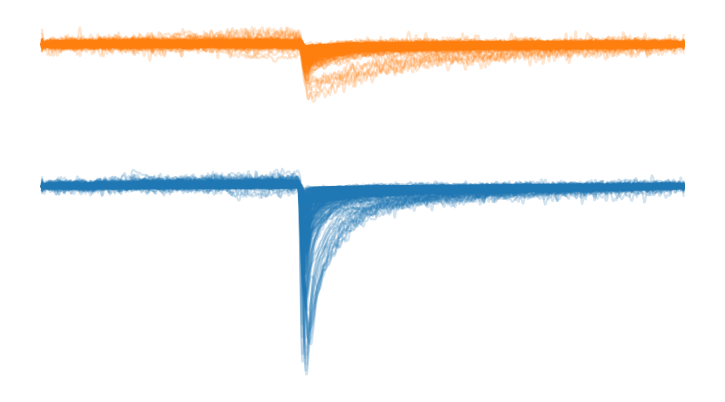

In [25]:
plt.figure(figsize=(10, 6))
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]
        for loc in slic_df['Location'].unique():
            loc_df = slic_df[slic_df['Location'] == loc]
            slic_loc_id = f"{slic}_{loc}"
            for ipi in loc_df['IPI'].unique():
                ipi_df = loc_df[loc_df['IPI'] == ipi]
                #print(f" {date} {slic_loc_id} IPI {ipi}ms")
                
                # for each ROI, there should be two rows in ipi_df, one for control 
                # (is_single_pulse_control = 1) and one for experimental
                # (is_single_pulse_control = 0)
                # the trace files are the same for each ROI, so we can just load them once
                control_df = ipi_df[ipi_df['is_single_pulse_control'] == 1]
                ppr_sub_df = ipi_df[ipi_df['is_single_pulse_control'] == 0]
                
                # load trace and trace_non_polyfit files
                control_filepath = control_df['trace'].values[0]
                if remapped_data_dir is not None:
                    control_filepath = control_filepath.replace( remapped_data_dir, data_dir)
                control_trace = read_dat_trace_file(control_filepath)
                control_filepath_non_polyfit = control_df['trace_non_polyfit'].values[0]
                if remapped_data_dir is not None:
                    control_filepath_non_polyfit = control_filepath_non_polyfit.replace( remapped_data_dir, data_dir)
                control_trace_non_polyfit = read_dat_trace_file(control_filepath_non_polyfit)
                ppr_filepath = ppr_sub_df['trace'].values[0]
                if remapped_data_dir is not None:
                    ppr_filepath = ppr_filepath.replace(remapped_data_dir, data_dir)
                ppr_trace = read_dat_trace_file(ppr_filepath)
                ppr_filepath_non_polyfit = ppr_sub_df['trace_non_polyfit'].values[0]
                if remapped_data_dir is not None:
                    ppr_filepath_non_polyfit = ppr_filepath_non_polyfit.replace(remapped_data_dir, data_dir)
                ppr_trace_non_polyfit = read_dat_trace_file(ppr_filepath_non_polyfit)

                # subtract non-polyfit control from ppr
                sub_non_polyfit = ppr_trace_non_polyfit - control_trace_non_polyfit

                # calculate the dist from zero of subtracted trace around the second stim
                trace_sub_dist = sub_non_polyfit[(sub_non_polyfit.index < 356) | (sub_non_polyfit.index > 550)].abs().mean()
                # normalize this to the max of the trace within the the second stim measure window
                trace_sub_dist = trace_sub_dist / sub_non_polyfit[(sub_non_polyfit.index > 356) | (sub_non_polyfit.index < 550)].max()

                # calculate maxAmp of subtracted trace in measure window of second stim (356-450)
                trace_sub_max = sub_non_polyfit[(sub_non_polyfit.index > 356) & (sub_non_polyfit.index < 450)].max()

                # perform baseline correction on control trace 
                first_stim_start = 356 - (ipi * 2)
                exclusion_window = (first_stim_start, first_stim_start + 290)
                bc = BaselineCorrection(control_trace_non_polyfit, exclusion_windows=[exclusion_window])
                control_trace_max = {}
                control_trace_corrected = {}
                for roi in control_trace.columns:
                    if roi == 'Pt':
                        continue
                    control_trace_corrected[roi] = bc.fit_baseline(roi, date+ " " + slic_loc_id + " IPI " + str(ipi) + "ms")
                    # measure MaxAmp of control trace in first stim site measure window

                    control_trace_max[roi] = control_trace_non_polyfit[(control_trace_non_polyfit.index > first_stim_start) 
                                                        & (control_trace_non_polyfit.index < first_stim_start + 104)]['Corrected_'+roi].max()

                # extract first and second maxAmp of ppr_trace. This is the non-subtracted PPR.
                first_maxAmp_non_sub = ppr_trace[(ppr_trace.index > first_stim_start) & 
                                                      (ppr_trace.index < 345)].max()
                second_maxAmp_non_sub = ppr_trace[(ppr_trace.index > 356) & (ppr_trace.index < 550)].max()

                # filter based on trace_sub_dist
                skip_plot = False
                if trace_sub_dist.mean() > 0.18:
                    skip_plot = True

                # plot all traces
                n_rois = len(control_trace.columns) - 1

                for i_roi, roi in enumerate(control_trace.columns):
                    
                    if roi == 'Pt':
                        continue
                    if not skip_plot:
                        t = control_trace.index * 0.5
                        if np.max(sub_non_polyfit[roi][:356]) > 2.5 or np.min(sub_non_polyfit[roi]) < -2.5:
                            continue
                        plt.plot(t, -sub_non_polyfit[roi] - (20 if roi == 'ROI1' else 0), 
                                label='Subtracted', 
                                color='tab:blue' if roi == 'ROI1' else 'tab:orange',
                                alpha=0.2)

#plt.legend(handles=[l1[0], l2[0]], labels=['Home Barrel', 'Neighbor Barrel'], loc='upper right')
plt.tight_layout()

# turn off spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.savefig(output_fig_dir + 'home_neighbor_traces.png')
plt.show()

In [26]:
# restrict to is_single_pulse_control = 0 (to avoid duplicates)
ppr_df = ppr_df[ppr_df['is_single_pulse_control'] == 0]

# and restrict to substring 'pulse1' in "ROI_Set" column (to avoid duplicates)
ppr_df = ppr_df[ppr_df['ROI_Set'].str.contains('pulse1')]

# how many unique date, slice, location combinations are there?
n_unique = len(ppr_df.groupby(['Date', 'Slice', 'Location']).size())
n_unique

29

In [27]:
ppr_df.columns

Index(['ROI', 'amp', 'latency', 'halfwidth', 'X_Center', 'Y_Center', 'ROI_Set',
       'Date', 'Slice', 'Location', 'Recording', 'trace', 'trace_non_polyfit',
       'amp_array', 'Medial/Lateral', 'Section', 'Rostral/Caudal',
       'pulse1_start', 'pulse1_width', 'pulse2_start', 'pulse2_width',
       'baseline_start', 'baseline_width', 'IPI', 'is_single_pulse_control',
       'done', 'Coronal/Sagittal', 'zda_id'],
      dtype='object')

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_33624\2604919270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Barrel_Type'] = filtered_df['ROI'].apply(lambda x: 'Home' if x == 1 else 'Neighbor')


          Date  Slice  Location Barrel_Type       ROI        amp     latency  \
0    1/15/2025      1         3        Home  1.000000   1.686665  116.671800   
1    1/15/2025      1         3    Neighbor  2.000000   0.236909  117.258700   
2    1/15/2025      3         2        Home  1.000000  22.781598  108.501327   
3    1/15/2025      3         2    Neighbor  2.000000   2.731071  107.689550   
4     1/2/2025      1         3        Home  1.000000   0.265125  113.318755   
5     1/2/2025      1         3    Neighbor  2.000000   0.247060  109.204010   
6     1/2/2025      2         2        Home  1.000000  10.009029  105.193483   
7     1/2/2025      2         2    Neighbor  2.000000   2.550743  103.629355   
8    1/22/2025      1         2        Home  1.000000   5.391039  110.272888   
9    1/22/2025      1         2    Neighbor  2.000000   3.354327  108.650196   
10   1/22/2025      3         2        Home  1.000000   8.190175  103.859160   
11   1/22/2025      3         2    Neigh

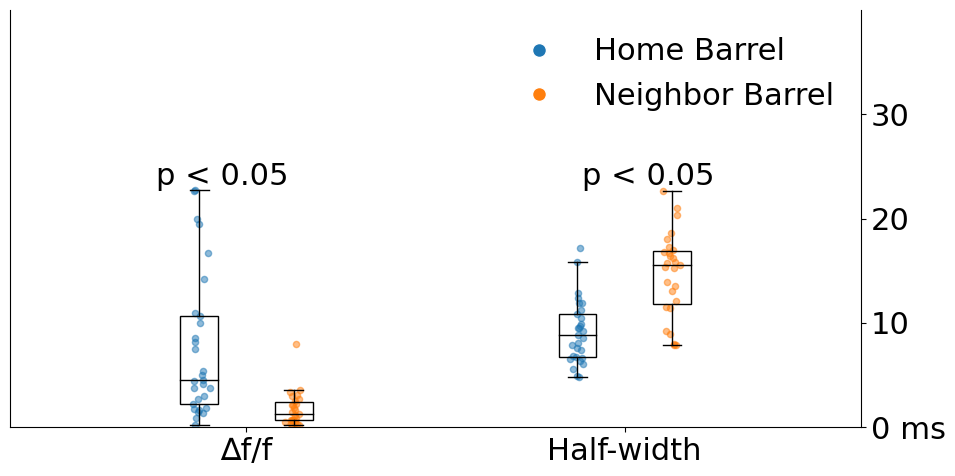

In [28]:
# compare amp, hw, latency for home barrel versus all other barrels
# Assuming `ppr_df` is your DataFrame and contains the necessary columns
# Filter for positive values

which_layer = 'L4'
filtered_df = ppr_df[(ppr_df['amp'] > 0) & (ppr_df['halfwidth'] > 0)]

# Add a column to distinguish between home barrel and other barrels
filtered_df['Barrel_Type'] = filtered_df['ROI'].apply(lambda x: 'Home' if x == 1 else 'Neighbor')
#filtered_df['amp'] /= 10 # convert to % change

plt.figure(figsize=(10, 6))

# average into a single value for each date, slice, location, and barrel type
filtered_df = filtered_df.groupby(['Date', 'Slice', 'Location', 'Barrel_Type']).mean().reset_index()
print(filtered_df)
print("Sample size home: ", len(filtered_df[filtered_df['Barrel_Type'] == 'Home']))
print("Sample size neighbor: ", len(filtered_df[filtered_df['Barrel_Type'] == 'Neighbor']))

# create boxplot and overlay with scatterplot. Do not use sns.boxplot() because it does not allow for jittering
for j, metric in enumerate(['amp', 'halfwidth']):
    for i, barrel_type in enumerate(['Home', 'Neighbor']):
        # Filter the DataFrame for the current barrel type
        filtered_subset = filtered_df[filtered_df['Barrel_Type'] == barrel_type]
        # Create a boxplot for the current metric and barrel type
        plt.boxplot(filtered_subset[metric], positions=[i * 0.25 + j], widths=0.1, patch_artist=True, 
                boxprops=dict(facecolor='none',
                color='black'), medianprops=dict(color='black'), showfliers=False)
        # Overlay with scatterplot (jittered)
        jittered_x = np.random.normal(j, 0.01, size=len(filtered_subset[metric]))
        plt.scatter(jittered_x + i * 0.25, filtered_subset[metric], 
                color=('tab:blue' if barrel_type == 'Home' else 'tab:orange'), alpha=0.5, s=20, label=barrel_type)
plt.xticks([0, 1], ['Home Barrel', 'Neighbor Barrel'], fontsize=22)
plt.yticks(fontsize=22)

# print the mean and std for each group
for barrel_type in ['Home', 'Neighbor']:
    mean_amp = filtered_df[filtered_df['Barrel_Type'] == barrel_type]['amp'].mean()
    std_amp = filtered_df[filtered_df['Barrel_Type'] == barrel_type]['amp'].std()
    mean_hw = filtered_df[filtered_df['Barrel_Type'] == barrel_type]['halfwidth'].mean()
    std_hw = filtered_df[filtered_df['Barrel_Type'] == barrel_type]['halfwidth'].std()
    print(f"{barrel_type} Barrel: Amp: {mean_amp:.2f} ± {std_amp:.2f}, Halfwidth: {mean_hw:.2f} ± {std_hw:.2f}")

# y label is ∆f/f (a. u.) at left and halfwidth (ms) at right
# no ticks at left y axis
plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.gca().yaxis.tick_left()
plt.gca().yaxis.set_label_position('left')
#plt.gca().set_ylabel('∆f/f (a. u.)', fontsize=22, labelpad=20)
plt.gca().yaxis.set_label_coords(-0.1, 0.5)  # Adjust the y-coordinate of the label position


# Customize the plot
#plt.title('Comparison of Amp, HW, and Latency: Home Barrel vs Other Barrels')
# legend shows only the first two labels
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Home Barrel',
                markerfacecolor='tab:blue', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='Neighbor Barrel',
                markerfacecolor='tab:orange', markersize=10)],
                loc='upper right', fontsize=22, frameon=False)
#plt.legend()
plt.tight_layout()

# significance testing
amp_home = filtered_df[filtered_df['Barrel_Type'] == 'Home']['amp']
amp_neighbor = filtered_df[filtered_df['Barrel_Type'] == 'Neighbor']['amp']
amp_ttest = ttest_ind(amp_home, amp_neighbor, equal_var=False)
amp_ttest_p = amp_ttest.pvalue
if amp_ttest_p < 0.05:
    print(f"Significant difference in amp between home and neighbor barrels: p = {amp_ttest_p:.4f}")
    print("T-test results:")
    print(f"t-statistic: {amp_ttest.statistic:.4f}, p-value: {amp_ttest.pvalue:.4f}")
    # add p < 0.05 label to the plot
    plt.text(0.25, 0.6, f"p < 0.05", ha='center', va='center', transform=plt.gca().transAxes, fontsize=22, color='black')

hw_home = filtered_df[filtered_df['Barrel_Type'] == 'Home']['halfwidth']
hw_neighbor = filtered_df[filtered_df['Barrel_Type'] == 'Neighbor']['halfwidth']
hw_ttest = ttest_ind(hw_home, hw_neighbor, equal_var=False)
hw_ttest_p = hw_ttest.pvalue
if hw_ttest_p < 0.05:
    print(f"Significant difference in halfwidth between home and neighbor barrels: p = {hw_ttest_p}")
    print("T-test results:")
    print(f"t-statistic: {hw_ttest.statistic:.4f}, p-value: {hw_ttest.pvalue:.4f}")
    # add p < 0.05 label to the plot
    plt.text(0.75, 0.60, f"p < 0.05", ha='center', va='center', transform=plt.gca().transAxes, fontsize=22, color='black')

#plt.ylabel('Value (∆f/f or ms)')
plt.ylim(0, 40)
plt.xticks([0.125, 1.125])
# set x tick labels 
plt.gca().set_xticklabels(['∆f/f', 'Half-width' ], fontsize=22)
plt.xlabel('')

# set y-label on the right side for halfwidth
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position('right')
#plt.gca().set_ylabel('Half-width (ms)', fontsize=22, labelpad=20)

plt.gca().spines['top'].set_visible(False)

# set y label ticks to be 0, 5, 10, 15
plt.gca().set_yticks([0, 10, 20, 30])
plt.gca().set_yticklabels(['0 ms', 10, 20, 30], fontsize=22)

# Show the plot
plt.savefig(output_fig_dir + 'home_vs_neighbor_barrels.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1
ppr_df = ppr_df[ppr_df['is_single_pulse_control'] == 0]
ppr_df = ppr_df[ppr_df['ROI_Set'].str.contains('pulse1')]

# Restrict to neighbor barrels (ROI > 1)
ppr_df = ppr_df[ppr_df['ROI'] > 1]

# barplot of hw, lat, and amp for rostral, caudal, medial, and lateral barrels

barrel_df = ppr_df.copy()

barrel_df.loc[barrel_df['Section'] == 'Sagittal', 'Barrel_Type'] = barrel_df[barrel_df['Section'] == 'Sagittal']['Rostral/Caudal']
barrel_df.loc[barrel_df['Section'] == 'Coronal', 'Barrel_Type'] = barrel_df[barrel_df['Section'] == 'Coronal']['Medial/Lateral']
barrel_df['latency'] -= (barrel_df['pulse1_start'] / 2 - 1.4)  # adjust latency to account for the first stim time
barrel_df 

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,...,pulse2_start,pulse2_width,baseline_start,baseline_width,IPI,is_single_pulse_control,done,Coronal/Sagittal,zda_id,Barrel_Type
1,2,0.330619,3.9850,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,356.0,70.0,236,220,60,0,1.0,Coronal,01_03_01,Lateral
9,2,0.122340,6.1130,10.10660,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,356.0,70.0,276,180,40,0,1.0,Coronal,01_03_04,Lateral
13,2,0.000000,169.4000,-361.92500,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,356.0,70.0,336,120,10,0,1.0,Coronal,01_03_05,Lateral
21,2,0.362766,5.1331,30.18870,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,356.0,70.0,96,360,130,0,1.0,Coronal,01_03_08,Lateral
27,2,0.135539,6.2248,16.74330,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,356.0,70.0,136,320,110,0,1.0,Coronal,01_03_10,Lateral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,2,0.402804,6.5430,9.34067,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,356.0,70.0,256,200,50,0,NaN,Sagittal,03_02_17,Rostral
2350,2,0.091472,7.7370,2.47492,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,356.0,70.0,296,160,30,0,NaN,Sagittal,03_02_19,Rostral
2356,2,0.381987,6.2895,8.43102,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,356.0,70.0,116,340,120,0,NaN,Sagittal,03_02_21,Rostral
2362,2,0.207280,3.6166,15.10230,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,356.0,70.0,176,280,90,0,NaN,Sagittal,03_02_23,Rostral


In [33]:
# read in final ladder velocities as well 'export_summary_final_velocity_ladders.csv'
#ladder_df = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/export_summary_final_velocity_ladders_backup.csv'
ladder_df = 'P:/John/analyzed_archived/crossing_PPR/crossing_PPR/export_summary_final_velocity_ladders_backup.csv'
ladder_df = pd.read_csv(ladder_df)

# only Layer == 'L4' 
ladder_df = ladder_df[ladder_df['Layer'] == 'L4']
ladder_df

,ROI,amp,snr,latency,halfwidth,Stim_Distance,X_Center,Y_Center,ROI_Set,Date,...,Coronal/Sagittal,IPI,Is_Pulse_2,Dist_from_home_barrel,resides_in_barrel,instantaneous_velocity,ROI file,Medial/Lateral,Age,Sex
202,1,1.148600,5.76071,4.1845,9.91258,309.741828,50.175676,8.337838,3_rois_output__ladder_,7/17/2024,...,NaN,NaN,False,388.536514,NaN,65.104863,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,NaN,62.0,F
203,2,1.463730,10.43580,3.9140,6.36216,293.264386,51.294872,11.051282,3_rois_output__ladder_,7/17/2024,...,NaN,NaN,False,370.925649,NaN,44.614970,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,NaN,62.0,F
204,3,1.585340,11.34920,3.5099,11.90630,274.758075,52.424658,13.835616,3_rois_output__ladder_,7/17/2024,...,NaN,NaN,False,352.896740,NaN,80.408649,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,NaN,62.0,F
205,4,1.998990,13.01990,3.7306,9.99551,255.264569,54.098592,16.352113,3_rois_output__ladder_,7/17/2024,...,NaN,NaN,False,335.150551,NaN,232.437797,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,NaN,62.0,F
206,5,2.664680,15.50890,3.8085,9.13839,239.774894,55.306667,19.120000,3_rois_output__ladder_,7/17/2024,...,NaN,NaN,False,317.043647,NaN,104.480100,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,NaN,62.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,21,0.392233,NaN,178.7470,5.93887,309.974193,35.278481,8.721519,3_rois_output__ladder_ pulse1,1/15/2025,...,Sagittal,120.0,True,82.732005,Neighbor,12.142742,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,35.0,M
9169,22,0.710792,NaN,177.4870,3.35339,339.835254,33.571429,6.311688,3_rois_output__ladder_ pulse1,1/15/2025,...,Sagittal,120.0,True,67.432150,Neighbor,24.621257,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,35.0,M
9170,23,1.011800,NaN,178.4610,28.19760,344.308002,29.714286,5.190476,3_rois_output__ladder_ pulse1,1/15/2025,...,Sagittal,120.0,True,43.451046,NaN,75.425673,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,35.0,M
9171,24,1.046040,NaN,178.1750,2.39320,365.754016,26.437500,3.708333,3_rois_output__ladder_ pulse1,1/15/2025,...,Sagittal,120.0,True,21.879303,NaN,18.463547,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,35.0,M


In [35]:
# read in hw/lat/amp data
#data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
data_dir = 'P:/John/analyzed_archived/crossing_PPR/crossing_PPR/L23_vs_L4_NBQX/'
hw_lat_data = data_dir + 'export_summary_hw_latency_amp.csv'
hw_lat_df = pd.read_csv(hw_lat_data)
hw_lat_df['latency'] -= 48.6
hw_lat_df

#nbqx_export_sagittal = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/sagittal_L4_NBQX/' + "export_summary_backup.csv"
nbqx_export_sagittal = 'P:/John/analyzed_archived/crossing_PPR/crossing_PPR/sagittal_L4_NBQX/' + "export_summary_backup.csv"
hw_lat_sagittal_df = pd.read_csv(nbqx_export_sagittal)
hw_lat_sagittal_df
hw_lat_df['Section'] = 'Coronal'
hw_lat_sagittal_df['Section'] = 'Sagittal'

# merge the two hw_lat dataframes
hw_lat_df = pd.concat([hw_lat_df, hw_lat_sagittal_df], ignore_index=True)

# only need drug == "ACSF"
hw_lat_df = hw_lat_df[hw_lat_df['drug'] == 'ACSF']

# only keep dates that are not already in barrel_df
hw_lat_df = hw_lat_df[~hw_lat_df['Date'].isin(barrel_df['Date'].unique())]

# only keep L4 in Layer column and ROI > 1
hw_lat_df = hw_lat_df[(hw_lat_df['Layer'] == 'L4') & (hw_lat_df['ROI'] > 1)]
hw_lat_df

,Layer,drug,ROI,amp,snr,latency,halfwidth,X_Center,Y_Center,ROI_Set,...,Slice,Location,Recording,Medial/Lateral,trace,Section,Stim_Distance,amp_array,snr_array,Rostral/Caudal
5,L4,ACSF,2,0.983708,39.2649,4.9494,12.78330,29.060606,33.034091,1_rois,...,1,1,1,Medial,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...,Coronal,NaN,NaN,NaN,NaN
9,L4,ACSF,2,3.041910,23.2155,2.3892,15.21730,51.851974,29.101974,2_rois,...,2,1,1,Lateral,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...,Coronal,NaN,NaN,NaN,NaN
21,L4,ACSF,2,12.553400,70.3597,2.0402,7.41857,52.287425,11.059880,1_rois,...,1,1,3,Lateral,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,Coronal,NaN,NaN,NaN,NaN
45,L4,ACSF,2,8.699790,42.8321,3.0089,6.29783,NaN,NaN,NaN,...,3,1,1,NaN,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,Coronal,NaN,NaN,NaN,NaN


In [36]:
# concat barrel_df and hw_lat_df and name it all_barrel_df
all_barrel_df = pd.concat([barrel_df, hw_lat_df], ignore_index=True)
all_barrel_df
# print all latencyes between 0 and 20
print("Latency values:", all_barrel_df[(all_barrel_df['latency'] > 0) & (all_barrel_df['latency'] <20)
                                       ]['latency'].unique())

Latency values: [ 3.985   6.113   5.1331  6.2248  7.642   7.227   6.9021  5.118   4.8864
  4.5178  5.193   6.4933  6.643   7.0896  7.986   7.186   7.592   7.546
  6.8707  7.251   6.307   6.577   6.7426  6.8667  5.1721  5.776   5.7077
  5.5289  5.783   5.4831  5.82    5.7715  6.378   5.824   5.893   5.678
  5.901   6.314   5.3848  6.023   5.8539  5.483   5.631   5.544   5.3634
  5.296   5.731   5.2345  5.681   5.3387  8.2793  8.8002  5.847   6.687
  5.81    6.415   5.3619  6.3265  5.8364  7.0966  6.271   7.643   5.7388
  7.4062  6.27    6.977   6.0832  6.8661  5.758   6.426   5.652   6.155
  6.471   6.065   6.455   6.6841  6.833   6.701   6.3425  7.027   6.6645
  6.739   6.2914  7.29    7.4478  7.373   7.265   9.176   5.207   4.755
  5.361   4.992   4.7131  5.09    5.051   4.9755  4.9764 16.755   5.138
  5.0192  5.1425  5.3759  4.9437  5.306   4.908   5.853   5.192   5.4075
  5.0151  5.655   5.53    5.465   5.698   5.48   19.4     5.1691  5.362
  6.3279  5.908   5.6276  5.9138  5.815   

In [38]:
#barrel_relation_df = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/all_barrels_relationships.csv'
barrel_relation_df = 'P:/John/analyzed_archived/crossing_PPR/crossing_PPR/all_barrels_relationships.csv'
barrel_relation_df = pd.read_csv(barrel_relation_df)
barrel_relation_df

,Date,Slice,Location,ROI,Is_Home_Barrel,Barrel_height,Barrel_width,Septa_width,Slice_Notes,Section,Relationship_to_home,Sex,Unnamed: 12
0,6/26/2024,1.0,1.0,1.0,True,131.590273,102.176318,NaN,NaN,Coronal,self,F,FALSE
1,6/26/2024,1.0,1.0,2.0,False,131.590273,106.150836,30.000000,small septa,Coronal,rostral row,F,FALSE
2,7/1/2024,3.0,2.0,1.0,True,102.703457,96.747093,NaN,NaN,Coronal,self,M,TRUE
3,7/1/2024,3.0,2.0,2.0,False,102.703457,87.361319,18.000000,small septa,Coronal,NaN,M,TRUE
4,7/1/2024,3.0,2.0,3.0,False,127.279221,187.541995,67.082039,large septa,Coronal,caudal row or arc,M,TRUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,4/16/2025,2.0,2.0,2.0,False,161.554944,121.490740,40.249224,small septa,Sagittal,caudal row or arc,F,FALSE
84,4/16/2025,2.0,2.0,3.0,False,161.554944,108.166538,43.680659,small septa,Sagittal,caudal row or arc,F,FALSE
85,4/16/2025,3.0,2.0,1.0,True,174.928557,157.035028,NaN,NaN,Sagittal,NaN,F,FALSE
86,4/16/2025,3.0,2.0,2.0,False,174.928557,168.428026,48.000000,small septa,Sagittal,caudal row or arc,F,FALSE


In [39]:

print(all_barrel_df['Date'].unique())
print(ladder_df['Date'].unique())
print(len(barrel_df['Date'].unique()), len(ladder_df['Date'].unique()), len(hw_lat_df['Date'].unique()))
print(all_barrel_df.columns, ladder_df.columns)

# create Barrel_Type column in ladder_df
ladder_df['Section'] = ''
ladder_df['Rostral/Caudal'] = ''
for date in ladder_df['Date'].unique():
    # find the matching row in barrel_relation_df
    match = barrel_relation_df[barrel_relation_df['Date'] == date]
    
    if not match.empty:
        # get the Section and Barrel_Type from the match
        section = match['Section'].values[0]
        
        # set the Section and Barrel_Type in ladder_df
        ladder_df.loc[ladder_df['Date'] == date, 'Section'] = section

    match_ab = all_barrel_df[all_barrel_df['Date'] == date]
    if not match_ab.empty:
        # fill out Medial/Lateral and Rostral/Caudal based on Section
        if section == 'Sagittal':
            ladder_df.loc[ladder_df['Date'] == date, 'Rostral/Caudal'] = match_ab['Rostral/Caudal'].values[0]
        elif section == 'Coronal':
            ladder_df.loc[ladder_df['Date'] == date, 'Medial/Lateral'] = match_ab['Medial/Lateral'].values[0]

ladder_df.loc[ladder_df['Section'] == 'Sagittal', 'Barrel_Type'] = ladder_df[ladder_df['Section'] == 'Sagittal']['Rostral/Caudal']
ladder_df.loc[ladder_df['Section'] == 'Coronal', 'Barrel_Type'] = ladder_df[ladder_df['Section'] == 'Coronal']['Medial/Lateral']

# print the number of unique dates in all_barrel_df and ladder_df where Barrel_Type is not empty
print("Unique dates in all_barrel_df with Barrel_Type:", len(all_barrel_df[all_barrel_df['Barrel_Type'].notna()]['Date'].unique()))
print("Unique dates in ladder_df with Barrel_Type:", len(ladder_df[ladder_df['Barrel_Type'].notna()]['Date'].unique()))
print(ladder_df['Barrel_Type'].unique(), all_barrel_df['Barrel_Type'].unique())
ladder_df


['1/2/2025' '1/7/2025' '11/6/2024' '12/11/2024' '12/18/2024' '12/20/2024'
 '12/23/2024' '1/15/2025' '1/22/2025' '2/5/2025' '4/9/2025' '4/16/2025'
 '12/9/2024' '10/29/2024' '7/17/2024']
['7/17/2024' '11/6/2024' '12/9/2024' '12/11/2024' '10/29/2024'
 '12/18/2024' '12/20/2024' '1/2/2025' '1/7/2025' '12/23/2024' '1/15/2025'
 '1/22/2025' '2/5/2025' '4/9/2025' '4/16/2025']
12 15 3
Index(['ROI', 'amp', 'latency', 'halfwidth', 'X_Center', 'Y_Center', 'ROI_Set',
       'Date', 'Slice', 'Location', 'Recording', 'trace', 'trace_non_polyfit',
       'amp_array', 'Medial/Lateral', 'Section', 'Rostral/Caudal',
       'pulse1_start', 'pulse1_width', 'pulse2_start', 'pulse2_width',
       'baseline_start', 'baseline_width', 'IPI', 'is_single_pulse_control',
       'done', 'Coronal/Sagittal', 'zda_id', 'Barrel_Type', 'Layer', 'drug',
       'snr', 'Stim_Distance', 'snr_array'],
      dtype='object') Index(['ROI', 'amp', 'snr', 'latency', 'halfwidth', 'Stim_Distance',
       'X_Center', 'Y_Center', 'ROI

,ROI,amp,snr,latency,halfwidth,Stim_Distance,X_Center,Y_Center,ROI_Set,Date,...,Dist_from_home_barrel,resides_in_barrel,instantaneous_velocity,ROI file,Medial/Lateral,Age,Sex,Section,Rostral/Caudal,Barrel_Type
202,1,1.148600,5.76071,4.1845,9.91258,309.741828,50.175676,8.337838,3_rois_output__ladder_,7/17/2024,...,388.536514,NaN,65.104863,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,NaN,62.0,F,Coronal,,NaN
203,2,1.463730,10.43580,3.9140,6.36216,293.264386,51.294872,11.051282,3_rois_output__ladder_,7/17/2024,...,370.925649,NaN,44.614970,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,NaN,62.0,F,Coronal,,NaN
204,3,1.585340,11.34920,3.5099,11.90630,274.758075,52.424658,13.835616,3_rois_output__ladder_,7/17/2024,...,352.896740,NaN,80.408649,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,NaN,62.0,F,Coronal,,NaN
205,4,1.998990,13.01990,3.7306,9.99551,255.264569,54.098592,16.352113,3_rois_output__ladder_,7/17/2024,...,335.150551,NaN,232.437797,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,NaN,62.0,F,Coronal,,NaN
206,5,2.664680,15.50890,3.8085,9.13839,239.774894,55.306667,19.120000,3_rois_output__ladder_,7/17/2024,...,317.043647,NaN,104.480100,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,NaN,62.0,F,Coronal,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,21,0.392233,NaN,178.7470,5.93887,309.974193,35.278481,8.721519,3_rois_output__ladder_ pulse1,1/15/2025,...,82.732005,Neighbor,12.142742,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,35.0,M,Sagittal,Caudal,Caudal
9169,22,0.710792,NaN,177.4870,3.35339,339.835254,33.571429,6.311688,3_rois_output__ladder_ pulse1,1/15/2025,...,67.432150,Neighbor,24.621257,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,35.0,M,Sagittal,Caudal,Caudal
9170,23,1.011800,NaN,178.4610,28.19760,344.308002,29.714286,5.190476,3_rois_output__ladder_ pulse1,1/15/2025,...,43.451046,NaN,75.425673,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,35.0,M,Sagittal,Caudal,Caudal
9171,24,1.046040,NaN,178.1750,2.39320,365.754016,26.437500,3.708333,3_rois_output__ladder_ pulse1,1/15/2025,...,21.879303,NaN,18.463547,C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...,NaN,35.0,M,Sagittal,Caudal,Caudal


In [40]:
for df in [all_barrel_df, ladder_df]:
    # add new column 'Detailed_Section', empty
    df['Detailed_Section'] = ''

    # in barrel_df['Crossing_Direction'], convert Lateral to Ventral and Medial to Dorsal
    df['Barrel_Type'] = df['Barrel_Type'].replace({'Lateral': 'Ventral', 'Medial': 'Dorsal'})

    # fill 'Detailed_Section' based on 'Section' and 'Relationship_to_home' in barrel_relation_df
    for i, row in df.iterrows():
        # look up the section and relationship in barrel_relation_df, matching on Date, Slice, Loc
        date = row['Date']
        slice_id, loc_id = int(row['Slice']), int(row['Location'])
        slice_id = int(slice_id)
        loc_id = int(loc_id)
        
        barrel_rel_row = barrel_relation_df[(barrel_relation_df['Date'] == date) & 
                                        (barrel_relation_df['Slice'] == slice_id) & 
                                        (barrel_relation_df['ROI'] > 1)]
        
        if barrel_rel_row.empty:
            print(f"No matching barrel relationship found for Date: {date}, Slice: {slice_id}, Loc: {loc_id}")
            print("unique dates in barrel_relation_df:", barrel_relation_df['Date'].unique())
            continue
        section = barrel_rel_row['Section'].values[0]
        relationship = barrel_rel_row['Relationship_to_home'].values[0]
        
        if section == 'Coronal':
            if relationship == 'rostral row':
                df.at[i, 'Detailed_Section'] = 'RAC'
            else:
                df.at[i, 'Detailed_Section'] = 'CAC'
        elif section == 'Sagittal':
            df.at[i, 'Detailed_Section'] = 'VAS'

    # concat Barrel_Type to the front of 'Detailed_Section'
    df['Detailed_Section'] = df['Barrel_Type'] + ' ' + df['Detailed_Section']
    print(df['Detailed_Section'].unique())

    # print the number of unique dates in all_barrel_df and ladder_df where Detailed_Section is not empty
    print("Unique dates in df with Detailed_Section:", len(df[df['Detailed_Section'].notna()]['Date'].unique()))

No matching barrel relationship found for Date: 1/22/2025, Slice: 3, Loc: 2
unique dates in barrel_relation_df: ['6/26/2024' '7/1/2024' '7/15/2024' '7/17/2024' '11/6/2024' '12/9/2024'
 '12/11/2024' '10/23/2024' '10/29/2024' '12/18/2024' '12/20/2024'
 '1/2/2025' '1/7/2025' '12/23/2024' '1/15/2025' '1/22/2025' '2/5/2025'
 '4/9/2025' '4/16/2025' nan]
No matching barrel relationship found for Date: 1/22/2025, Slice: 3, Loc: 2
unique dates in barrel_relation_df: ['6/26/2024' '7/1/2024' '7/15/2024' '7/17/2024' '11/6/2024' '12/9/2024'
 '12/11/2024' '10/23/2024' '10/29/2024' '12/18/2024' '12/20/2024'
 '1/2/2025' '1/7/2025' '12/23/2024' '1/15/2025' '1/22/2025' '2/5/2025'
 '4/9/2025' '4/16/2025' nan]
No matching barrel relationship found for Date: 1/22/2025, Slice: 3, Loc: 2
unique dates in barrel_relation_df: ['6/26/2024' '7/1/2024' '7/15/2024' '7/17/2024' '11/6/2024' '12/9/2024'
 '12/11/2024' '10/23/2024' '10/29/2024' '12/18/2024' '12/20/2024'
 '1/2/2025' '1/7/2025' '12/23/2024' '1/15/2025' '1

In [41]:
all_barrel_df

,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,...,done,Coronal/Sagittal,zda_id,Barrel_Type,Layer,drug,snr,Stim_Distance,snr_array,Detailed_Section
0,2,0.330619,3.9850,30.66020,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,1.0,Coronal,01_03_01,Ventral,NaN,NaN,NaN,NaN,NaN,Ventral RAC
1,2,0.122340,6.1130,10.10660,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,1.0,Coronal,01_03_04,Ventral,NaN,NaN,NaN,NaN,NaN,Ventral RAC
2,2,0.000000,169.4000,-361.92500,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,1.0,Coronal,01_03_05,Ventral,NaN,NaN,NaN,NaN,NaN,Ventral RAC
3,2,0.362766,5.1331,30.18870,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,1.0,Coronal,01_03_08,Ventral,NaN,NaN,NaN,NaN,NaN,Ventral RAC
4,2,0.135539,6.2248,16.74330,44.112853,28.366771,1_rois pulse1,1/2/2025,1,3,...,1.0,Coronal,01_03_10,Ventral,NaN,NaN,NaN,NaN,NaN,Ventral RAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,2,0.140123,4.4780,7.39186,24.504732,41.558360,3_rois pulse1,4/16/2025,3,2,...,NaN,Sagittal,03_02_26,Rostral,NaN,NaN,NaN,NaN,NaN,Rostral VAS
439,2,0.983708,4.9494,12.78330,29.060606,33.034091,1_rois,12/9/2024,1,1,...,NaN,NaN,NaN,NaN,L4,ACSF,39.2649,NaN,NaN,NaN
440,2,3.041910,2.3892,15.21730,51.851974,29.101974,2_rois,12/9/2024,2,1,...,NaN,NaN,NaN,NaN,L4,ACSF,23.2155,NaN,NaN,NaN
441,2,12.553400,2.0402,7.41857,52.287425,11.059880,1_rois,10/29/2024,1,1,...,NaN,NaN,NaN,NaN,L4,ACSF,70.3597,NaN,NaN,NaN


In [42]:
# test normality of the data
from scipy.stats import shapiro

def test_normality(df, metric):
    """Test normality of the data using Shapiro-Wilk test."""
    stat, p = shapiro(df[metric])
    print(f"Shapiro-Wilk test for {metric}: Statistics={stat:.3f}, p-value={p:.3f}, n={len(df[metric])}")
    if p > 0.05:
        print(f"The {metric} data is normally distributed (fail to reject H0)")
    else:
        print(f"The {metric} data is not normally distributed (reject H0)")

Shapiro-Wilk test for halfwidth: Statistics=0.967, p-value=0.865, n=10
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.884, p-value=0.330, n=5
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.870, p-value=0.187, n=7
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.870, p-value=0.187, n=7
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.962, p-value=0.825, n=8
The halfwidth data is normally distributed (fail to reject H0)
Caudal halfwidth: 14.58 ± 1.32
Sample size Caudal: 10
Dorsal halfwidth: 14.04 ± 1.32
Sample size Dorsal: 8
Rostral halfwidth: 13.51 ± 1.60
Sample size Rostral: 8
Ventral halfwidth: 15.46 ± 1.27
Sample size Ventral: 10
No significant difference in halfwidth between Caudal and Dorsal: p = 0.7737
No significant difference in halfwidth 

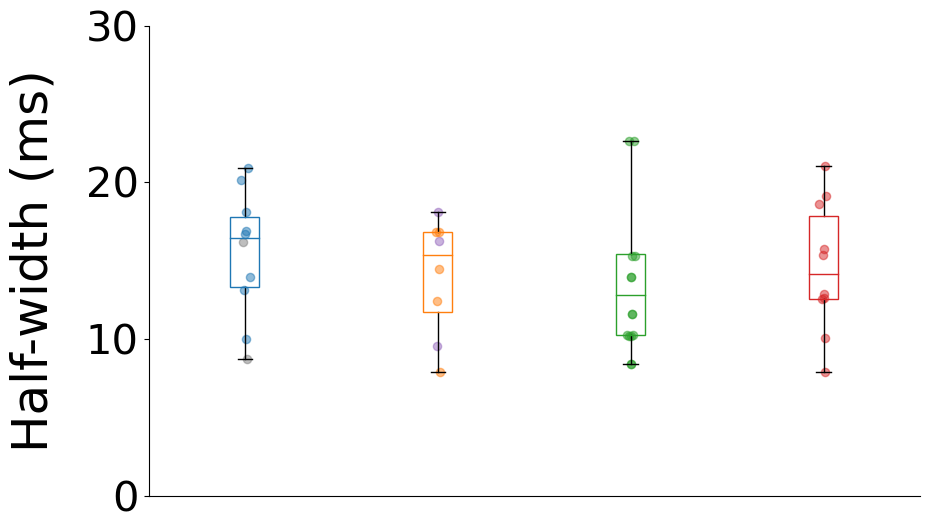

Shapiro-Wilk test for latency: Statistics=0.918, p-value=0.338, n=10
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.921, p-value=0.535, n=5
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.919, p-value=0.463, n=7
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.919, p-value=0.463, n=7
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.818, p-value=0.044, n=8
The latency data is not normally distributed (reject H0)
Caudal latency: 6.16 ± 0.21
Sample size Caudal: 10
Dorsal latency: 6.13 ± 0.31
Sample size Dorsal: 8
Rostral latency: 5.75 ± 0.39
Sample size Rostral: 8
Ventral latency: 5.91 ± 0.25
Sample size Ventral: 10
y_space: 7.8602784706959765 x_space1: 4 x_space2: 2
No significant difference in latency between Caudal and Rostral: p = 0.3745
No significant differenc

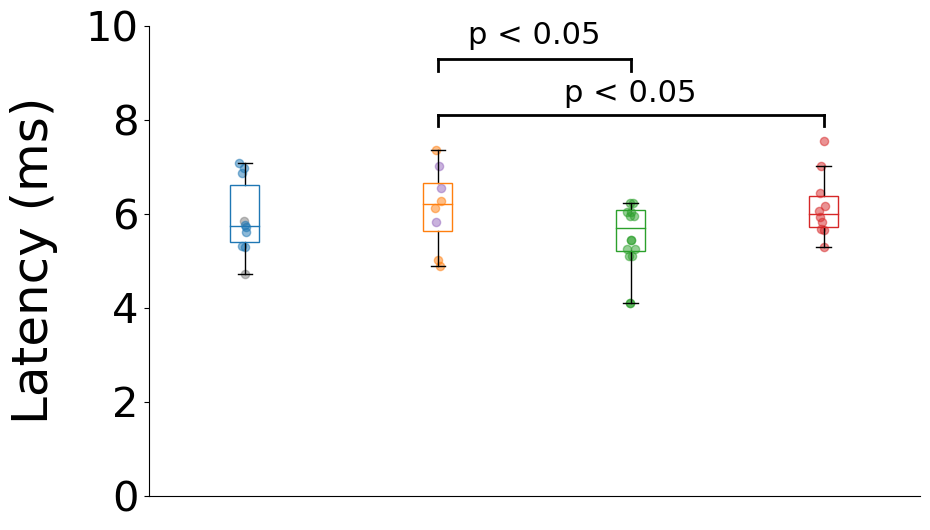

In [43]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1

all_barrel_df['Detailed_Section'] = all_barrel_df['Detailed_Section'].astype('category')
all_barrel_df['Barrel_Type'] = all_barrel_df['Barrel_Type'].astype('category')

# font size
plt.rcParams.update({'font.size': 30})

detailed_directions = ['Ventral RAC', 'Dorsal RAC', 'Rostral VAS', 'Caudal VAS', 'Ventral CAC', 'Dorsal CAC']
det_dir_colors = {'Ventral CAC': 'tab:gray',
                  'Dorsal RAC': 'tab:orange',
                  'Ventral RAC': 'tab:blue',
                  'Dorsal CAC': 'tab:purple',
                  'Caudal VAS': 'tab:red',
                  'Rostral VAS': 'tab:green'}
barrel_types = ['Ventral', 'Dorsal', 'Rostral', 'Caudal']
box_colors = {
    'Ventral': 'tab:blue',
    'Dorsal': 'tab:orange',
    'Rostral': 'tab:green',
    'Caudal': 'tab:red',}

# don't use seaborn, use matplotlib
# and plot only positive values

grouped_dfs = {}

for metric in ['halfwidth', 'latency']:
    if metric == 'latency':
        plt.figure(figsize=(10, 6))
    elif metric == 'halfwidth':
        plt.figure(figsize=(10, 6))
    handles = []
    for barrel_type in all_barrel_df['Detailed_Section'].cat.categories:
        # filter for positive values
        already_in_handles = False
        if barrel_type in ["Rostral", "Rostral "]:
            barrel_type = "Rostral VAS"  
            already_in_handles = True
        barrel_type_lumped = barrel_type.split(' ')[0]  # get the first part of the barrel type
        
        df = all_barrel_df.copy()
        df = df[df['Detailed_Section'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = det_dir_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + barrel_types.index(barrel_type_lumped) 

        # scatter and jitter the data points
        jittered_x = np.random.normal(x_space, 0.01, size=len(df[metric]))
        l1 = plt.scatter(jittered_x, df[metric], color=color, alpha=0.5, s=35, label=barrel_type.replace("A", '-').replace("V-S", 'L-S'))
        #l1 = plt.bar(x_space, df[metric].mean(), color=color, alpha=0.5, width=0.1, label=barrel_type)
        if not already_in_handles:
            handles.append(l1)

        if len(df[metric]) > 3:
            test_normality(df, metric)

        #plt.errorbar(x_space, df[metric].mean(), yerr=sem(df[metric]), fmt='o', color=color, capsize=5, markersize=5)
    for barrel_type in all_barrel_df['Barrel_Type'].cat.categories:

        df = all_barrel_df.copy()
        df = df[df['Barrel_Type'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = box_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + barrel_types.index(barrel_type) 

        # boxplot the data points
        plt.boxplot(df[metric], positions=[x_space], 
                    patch_artist=True, boxprops=dict(facecolor='none', color=color), 
                    medianprops=dict(color=color), showfliers=False)

        # print the mean and sem for each group
        print(f"{barrel_type} {metric}: {df[metric].mean():.2f} ± {sem(df[metric]):.2f}")
        # and sample size after grouping by date, slice, location
        df_grouped = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        print(f"Sample size {barrel_type}: {len(df_grouped)}")

        if metric not in grouped_dfs:
            grouped_dfs[metric] = {}
        grouped_dfs[metric][barrel_type] = df_grouped
        
    # significance testing
    next_bar = 1
    barrel_types_cats = all_barrel_df['Barrel_Type'].cat.categories
    for i1 in range(len(barrel_types_cats)):
        barrel_type1 = barrel_types_cats[i1]
        for i2 in range(i1 + 1, len(barrel_types_cats)):
            barrel_type2 = barrel_types_cats[i2]
            df1 = grouped_dfs[metric][barrel_type1]
            df2 = grouped_dfs[metric][barrel_type2]
            ttest_result = ttest_ind(df1[metric], df2[metric], equal_var=False)
            # add Tukey's significant difference label to the plot for latency: caudal vs dorsal, rostral vs dorsal
            if metric == 'latency' and \
                (barrel_type1 == 'Caudal' and barrel_type2 == 'Dorsal' or \
                barrel_type1 == 'Rostral' and barrel_type2 == 'Dorsal' or \
                barrel_type1 =='Dorsal' and barrel_type2 == 'Caudal' or \
                barrel_type1 == 'Dorsal' and barrel_type2 == 'Rostral'):
                    
                    
                y_space = max(df1[metric].mean(), df2[metric].mean()) + 0.7 + next_bar
                x_space1 = 1 + barrel_types.index(barrel_type1)
                x_space2 = 1 + barrel_types.index(barrel_type2)
                print("y_space:", y_space, "x_space1:", x_space1, "x_space2:", x_space2)
                plt.text((x_space1 + x_space2) / 2, y_space * 1.05, f"p < 0.05", ha='center', va='bottom', fontsize=22, color='black')

                # add a line between the two bars
                plt.plot([x_space1, x_space2], [y_space * 1.03, y_space * 1.03], color='black', linewidth=2)

                # add caps on ends of line
                plt.plot([x_space1, x_space1], [y_space * 1.03, y_space * 1], color='black', linewidth=2)
                plt.plot([x_space2, x_space2], [y_space * 1.03, y_space * 1], color='black', linewidth=2)
                next_bar += 1.2
            else:
                print(f"No significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")

    # ANOVA comparison of all barrel types
    anova_df = all_barrel_df.copy()
    # filter out rows where Barrel_Type is NaN or metric is not positive
    anova_df = anova_df[anova_df['Barrel_Type'].notna()]
    anova_df = anova_df[anova_df[metric] > 0]
    anova_df = anova_df.groupby(['Date', 'Slice', 'Location', 'Barrel_Type']).mean().reset_index()
    anova_df['Barrel_Type'] = anova_df['Barrel_Type'].astype('category')
    model = ols(f"{metric} ~ C(Barrel_Type)", data=anova_df).fit()
    anova_results = anova_lm(model, typ=2)
    print(f"\n\nANOVA results for {metric}:")
    print(anova_results)

    # Tukey's HSD test for post-hoc analysis
    clean_tukey_df = anova_df.filter(items=[metric, 'Barrel_Type']).dropna()
    tukey = pairwise_tukeyhsd(endog=clean_tukey_df[metric],
                                 groups=clean_tukey_df['Barrel_Type'],
                                    alpha=0.05)
    print("\nTukey's HSD test results:")
    print(tukey)

    if metric == 'halfwidth':
        # place the legend to the left of the plot
        plt.yticks([0, 10, 20,  30], fontsize=30)
        plt.ylim(0, 30)
        plt.ylabel('Half-width (ms)', fontsize=36, labelpad=20)
    elif metric == 'latency':
        #plt.legend(handles=handles[:6], loc='lower left', fontsize=22, ncol=2)

        plt.ylabel('Latency (ms)', fontsize=36, labelpad=20)
        plt.yticks([0, 2, 4, 6, 8, 10], fontsize=30)
        plt.ylim(0, 10)
    
    #plt.xticks([0.25, 0.5, 0.75, 1], ['Rostral', 'Caudal', 'Medial', 'Lateral'], fontsize=24)
    plt.xticks([])
    #plt.xlim(-0.23250000000000004, 3.2325000000000004)
    plt.tight_layout()


    # set spines to be invisible
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.savefig(output_fig_dir + 'rostro_caudal_medial_lateral_barrels_' + metric + '.png', dpi=300, bbox_inches='tight')
    plt.show()


Shapiro-Wilk test for halfwidth: Statistics=0.967, p-value=0.865, n=10
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.884, p-value=0.330, n=5
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.870, p-value=0.187, n=7
The halfwidth data is normally distributed (fail to reject H0)
Shapiro-Wilk test for halfwidth: Statistics=0.962, p-value=0.825, n=8
The halfwidth data is normally distributed (fail to reject H0)
Ventral RAC
Coronal halfwidth: 13.68 ± 0.99
Sample size Coronal: 18
Ventral RAC
Sagittal halfwidth: 14.85 ± 1.21
Sample size Sagittal: 13
Overal halfwidth: 14.17 ± 0.76
No significant difference in halfwidth between Coronal and Sagittal: p = 0.4604
T-test results:
t-statistic: -0.7495, p-value: 0.4604


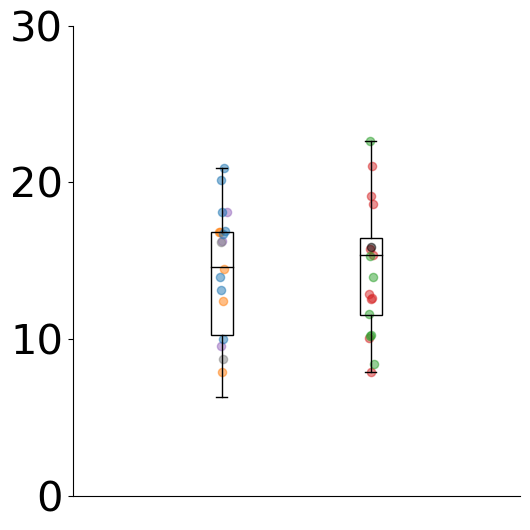

Shapiro-Wilk test for latency: Statistics=0.918, p-value=0.338, n=10
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.921, p-value=0.535, n=5
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.919, p-value=0.463, n=7
The latency data is normally distributed (fail to reject H0)
Shapiro-Wilk test for latency: Statistics=0.818, p-value=0.044, n=8
The latency data is not normally distributed (reject H0)
Ventral RAC
Coronal latency: 5.41 ± 0.37
Sample size Coronal: 18
Ventral RAC
Sagittal latency: 6.15 ± 0.24
Sample size Sagittal: 13
Overal latency: 5.72 ± 0.24
No significant difference in latency between Coronal and Sagittal: p = 0.1064
T-test results:
t-statistic: -1.6694, p-value: 0.1064


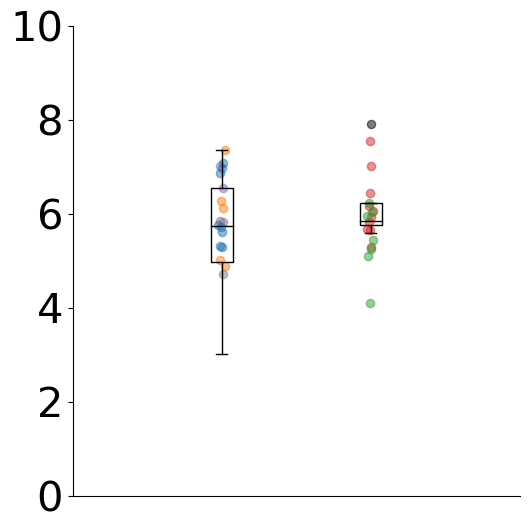

In [44]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1

all_barrel_df['Detailed_Section'] = all_barrel_df['Detailed_Section'].astype('category')
all_barrel_df['Section'] = all_barrel_df['Section'].astype('category')

# font size
plt.rcParams.update({'font.size': 30})

sections = ['Coronal', 'Sagittal']
section_colors = {
    'Coronal': 'tab:blue',
    'Sagittal': 'red',
}

# don't use seaborn, use matplotlib
# and plot only positive values

grouped_dfs = {}

for metric in ['halfwidth', 'latency']:
    plt.figure(figsize=(6, 6))

    handles = []
    for barrel_type in all_barrel_df['Detailed_Section'].cat.categories:
        # filter for positive values
        section = 'Coronal' if barrel_type.endswith("AC") else 'Sagittal'
        df = all_barrel_df.copy()
        df = df[df['Detailed_Section'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = det_dir_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + sections.index(section) 

        # scatter and jitter the data points
        jittered_x = np.random.normal(x_space, 0.01, size=len(df[metric]))
        l1 = plt.scatter(jittered_x, df[metric], color=color, alpha=0.5, s=35, label=barrel_type)
        #l1 = plt.bar(x_space, df[metric].mean(), color=color, alpha=0.5, width=0.1, label=barrel_type)
        handles.append(l1)

        if len(df[metric]) > 3:
            test_normality(df, metric)

        #plt.errorbar(x_space, df[metric].mean(), yerr=sem(df[metric]), fmt='o', color=color, capsize=5, markersize=5)
    for section in all_barrel_df['Section'].cat.categories:

        df = all_barrel_df.copy()
        df = df[df['Section'] == section]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        print(barrel_type)
        color = box_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + sections.index(section) 

        # boxplot the data points
        plt.boxplot(df[metric], positions=[x_space], 
                    patch_artist=True, boxprops=dict(facecolor='none', color=color), 
                    medianprops=dict(color=color), showfliers=False)

        # print the mean and sem for each group
        print(f"{section} {metric}: {df[metric].mean():.2f} ± {sem(df[metric]):.2f}")
        # and sample size after grouping by date, slice, location
        df_grouped = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        print(f"Sample size {section}: {len(df_grouped)}")

        if metric not in grouped_dfs:
            grouped_dfs[metric] = {}
        grouped_dfs[metric][section] = df_grouped
    
    df = all_barrel_df.copy()
    if metric == 'latency':
            df = df[df[metric] < 20]
    df = df[df[metric] > 0]
    #filter nan
    df = df[df[metric].notna()]
    df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
    print(f"Overal {metric}: {df[metric].mean():.2f} ± {sem(df[metric]):.2f}")

    # significance testing
    next_bar = 0
    section_t = all_barrel_df['Section'].cat.categories
    for i1 in range(len(section_t)):
        barrel_type1 = section_t[i1]
        for i2 in range(i1 + 1, len(section_t)):
            barrel_type2 = section_t[i2]
            df1 = grouped_dfs[metric][barrel_type1]
            df2 = grouped_dfs[metric][barrel_type2]
            ttest_result = ttest_ind(df1[metric], df2[metric], equal_var=False)
            if ttest_result.pvalue < 0.05:
                print(f"Significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")
                # add p < 0.05 label to the plot above the bars
                y_space = max(df1[metric].mean(), df2[metric].mean()) + 0.7 + next_bar
                x_space1 = 1 + sections.index(barrel_type1)
                x_space2 = 1 + sections.index(barrel_type2)
                plt.text(x_space1 + 0.25, 6.5, f"p < 0.05", ha='center', va='bottom', fontsize=22, color='black')

                # add a line between the two bars
                plt.plot([x_space1, x_space2], [y_space * 1.1, y_space * 1.1], color='black', linewidth=2)

                # add caps on ends of line
                plt.plot([x_space1, x_space1], [y_space * 1.1, y_space * 0.9], color='black', linewidth=2)
                plt.plot([x_space2, x_space2], [y_space * 1.1, y_space * 0.9], color='black', linewidth=2)
                next_bar += 1
            else:
                print(f"No significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")

    if metric == 'halfwidth':
        # place the legend to the left of the plot
        plt.yticks([0, 10, 20,  30], fontsize=30)
        plt.ylim(0, 30)
        #plt.ylabel('Half-width (ms)', fontsize=40, labelpad=20)
    elif metric == 'latency':
        #plt.legend(handles=handles, loc='lower left', fontsize=22, ncol=2)

        #plt.ylabel('Latency (ms)', fontsize=40, labelpad=20)
        plt.yticks([0, 2, 4, 6, 8, 10], fontsize=30)
        plt.ylim(0, 10)
    
    #plt.xticks([0.25, 0.5, 0.75, 1], ['Rostral', 'Caudal', 'Medial', 'Lateral'], fontsize=24)
    plt.xticks([])
    plt.xlim(0, 3)
    plt.tight_layout()


    # set spines to be invisible
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.savefig(output_fig_dir + 'coronal_sagittal_barrels_' + metric + '.png', dpi=300, bbox_inches='tight')
    plt.show()


In [48]:
ladder_df.columns

Index(['ROI', 'amp', 'snr', 'latency', 'halfwidth', 'Stim_Distance',
       'X_Center', 'Y_Center', 'ROI_Set', 'Date', 'Slice', 'Location',
       'Recording', 'trace', 'drug', 'Layer', 'Coronal/Sagittal', 'IPI',
       'Is_Pulse_2', 'Dist_from_home_barrel', 'resides_in_barrel',
       'instantaneous_velocity', 'ROI file', 'Medial/Lateral', 'Age', 'Sex',
       'Section', 'Rostral/Caudal', 'Barrel_Type', 'Detailed_Section'],
      dtype='object')

1179     59.992779
1180     34.210721
1181     99.448681
1182    102.273456
1183    109.085955
1184    116.123099
1185     24.455106
1186    109.117144
1187     73.770492
1188    189.473684
1189    610.881590
1190     53.227564
1191     63.118947
1192    233.033037
1193    346.067910
1194     80.690768
1195     50.538363
1196     45.993596
1197     33.497954
1198     37.561388
1199     41.474654
1200     37.894737
1201           NaN
Name: instantaneous_velocity, dtype: float64       ROI       amp  snr  latency  halfwidth  Stim_Distance   X_Center  \
1179    1   6.11700  NaN   94.333    6.11700     282.764920  49.000000   
1180    2   2.78085  NaN   94.033    2.78085     265.631324  49.000000   
1181    3  14.19530  NaN   94.563   14.19530     248.620192  49.500000   
1182    4  12.87640  NaN   94.383   12.87640     231.758495  49.505618   
1183    5  12.76980  NaN   94.208   12.76980     215.081380  49.500000   
1184    6  13.24310  NaN   94.043   13.24310     198.635344  49.500000   


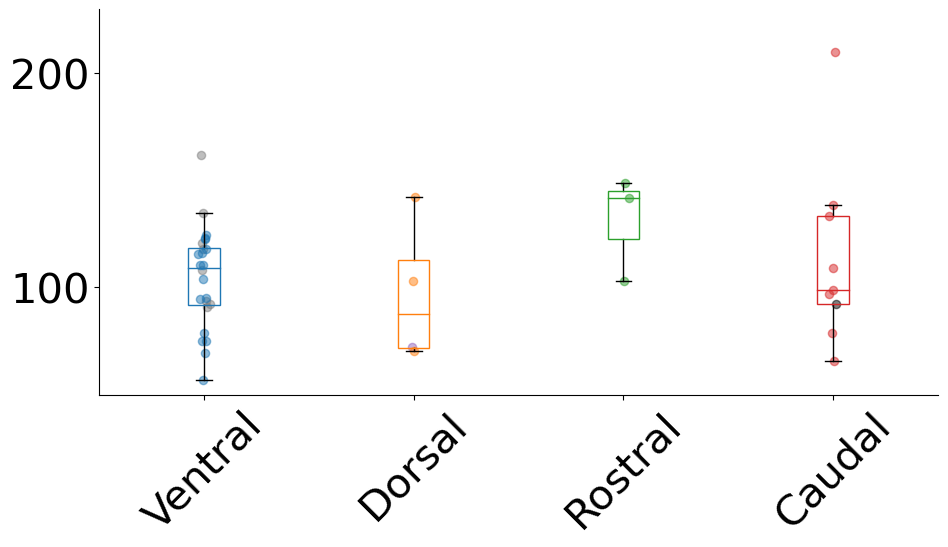

In [54]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1

ladder_df['Detailed_Section'] = ladder_df['Detailed_Section'].astype('category')
ladder_df['Barrel_Type'] = ladder_df['Barrel_Type'].astype('category')

# font size
plt.rcParams.update({'font.size': 24})

detailed_directions = ['Ventral RAC', 'Dorsal RAC',   'Rostral VAS', 'Caudal VAS', 'Ventral CAC', 'Dorsal CAC']
det_dir_colors = {'Ventral CAC': 'tab:gray',
                  'Dorsal RAC': 'tab:orange',
                  'Ventral RAC': 'tab:blue',
                  'Dorsal CAC': 'tab:purple',
                  'Caudal VAS': 'tab:red',
                  'Rostral VAS': 'tab:green'}
barrel_types = ['Ventral', 'Dorsal', 'Rostral', 'Caudal']
box_colors = {
    'Ventral': 'tab:blue',
    'Dorsal': 'tab:orange',
    'Rostral': 'tab:green',
    'Caudal': 'tab:red',}

# don't use seaborn, use matplotlib
# and plot only positive values

grouped_dfs = {}

for metric in ['instantaneous_velocity', ]:
    plt.figure(figsize=(10, 6))
    handles = []
    for barrel_type in ladder_df['Detailed_Section'].cat.categories:
        # filter for positive values
        barrel_type_lumped = barrel_type.split(' ')[0]  # get the first part of the barrel type
        df = ladder_df.copy()
        df = df[df['Detailed_Section'] == barrel_type]
        print(df['instantaneous_velocity'], df)

        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        if metric == 'instantaneous_velocity':
            df = df[(df[metric] < 500)]
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = det_dir_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + barrel_types.index(barrel_type_lumped) 

        # scatter and jitter the data points
        jittered_x = np.random.normal(x_space, 0.01, size=len(df[metric]))
        l1 = plt.scatter(jittered_x, df[metric], color=color, alpha=0.5, s=35, label=barrel_type)
        #l1 = plt.bar(x_space, df[metric].mean(), color=color, alpha=0.5, width=0.1, label=barrel_type)
        handles.append(l1)

        if len(df[metric]) > 3:
            test_normality(df, metric)

        #plt.errorbar(x_space, df[metric].mean(), yerr=sem(df[metric]), fmt='o', color=color, capsize=5, markersize=5)
    for barrel_type in ladder_df['Barrel_Type'].cat.categories:

        df = ladder_df.copy()
        df = df[df['Barrel_Type'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        if metric == 'instantaneous_velocity':
            # outliers 
            df = df[(df[metric] < 500)]

        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = box_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + barrel_types.index(barrel_type) 

        # boxplot the data points
        plt.boxplot(df[metric], positions=[x_space], 
                    patch_artist=True, boxprops=dict(facecolor='none', color=color), 
                    medianprops=dict(color=color), showfliers=False)

        # print the mean and sem for each group
        print(f"{barrel_type} {metric}: {df[metric].mean():.2f} ± {sem(df[metric]):.2f}")
        # and sample size after grouping by date, slice, location
        df_grouped = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        print(f"Sample size {barrel_type}: {len(df_grouped)}")

        if metric not in grouped_dfs:
            grouped_dfs[metric] = {}
        grouped_dfs[metric][barrel_type] = df_grouped

    # anova comparison of all barrel types
    anova_df = ladder_df.copy()
    anova_df = anova_df[anova_df['Barrel_Type'].notna()]
    anova_df = anova_df[anova_df[metric] > 0]
    anova_df = anova_df.groupby(['Date', 'Slice', 'Location', 'Barrel_Type']).mean().reset_index()
    anova_df['Barrel_Type'] = anova_df['Barrel_Type'].astype('category')
    model = ols(f"{metric} ~ C(Barrel_Type)", data=anova_df).fit()
    anova_results = anova_lm(model, typ=2)
    print(f"\n\nANOVA results for {metric}:")
    print(anova_results)

    # Tukey's HSD test for post-hoc analysis
    clean_tukey_df = anova_df.filter(items=[metric, 'Barrel_Type']).dropna()
    tukey = pairwise_tukeyhsd(endog=clean_tukey_df[metric],
                                 groups=clean_tukey_df['Barrel_Type'],
                                    alpha=0.05)
    print("\nTukey's HSD test results:")
    print(tukey)

    # significance testing
    next_bar = 0
    barrel_types_cats = ladder_df['Barrel_Type'].cat.categories
    for i1 in range(len(barrel_types_cats)):
        barrel_type1 = barrel_types_cats[i1]
        for i2 in range(i1 + 1, len(barrel_types_cats)):
            barrel_type2 = barrel_types_cats[i2]
            df1 = grouped_dfs[metric][barrel_type1]
            df2 = grouped_dfs[metric][barrel_type2]
            ttest_result = ttest_ind(df1[metric], df2[metric], equal_var=False)

            if ttest_result.pvalue < 0.05:
                print(f"Significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")
                # add p < 0.05 label to the plot above the bars
                y_space = max(df1[metric].mean(), df2[metric].mean()) + 25 + next_bar
                x_space1 = 1 + barrel_types.index(barrel_type1)
                x_space2 = 1 + barrel_types.index(barrel_type2)
                '''plt.text((x_space1 + x_space2 ) / 2, y_space+30, f"p < 0.05", ha='center', va='bottom', fontsize=22, color='black')

                # add a line between the two bars
                plt.plot([x_space1, x_space2], [y_space * 1.1, y_space * 1.1], color='black', linewidth=2)

                # add caps on ends of line
                plt.plot([x_space1, x_space1], [y_space * 1.1, y_space * 0.95], color='black', linewidth=2)
                plt.plot([x_space2, x_space2], [y_space * 1.1, y_space * 0.95], color='black', linewidth=2)'''
                next_bar += 50
            else:
                print(f"No significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")

    if metric == 'instantaneous_velocity':
        # significance between rostral and caudal barrels (RAC vs CAC)
        non_nan_df = ladder_df[ladder_df['Detailed_Section'].notna()]
        rac_df = non_nan_df[non_nan_df['Detailed_Section'].str.contains('RAC')]
        cac_df = non_nan_df[non_nan_df['Detailed_Section'].str.contains('CAC')]
        rac_df = rac_df[rac_df[metric] > 0]
        cac_df = cac_df[cac_df[metric] > 0]
        # remove outliers greater than 500
        rac_df = rac_df[rac_df[metric] < 500]
        cac_df = cac_df[cac_df[metric] < 500]
        # group by date, slice, and location
        rac_df = rac_df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        cac_df = cac_df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        ttest_result = ttest_ind(rac_df[metric], cac_df[metric], equal_var=False)
        print(f"Significant difference in {metric} between RAC and CAC barrels: p = {ttest_result.pvalue:.4f}")
        print("T-test results:")
        print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")
        print("RAC mean velocity: ", rac_df[metric].mean(), "±", sem(rac_df[metric]))
        print("CAC mean velocity: ", cac_df[metric].mean(), "±", sem(cac_df[metric]))
    if metric == 'halfwidth':
        # place the legend to the left of the plot
        plt.yticks([0, 10, 20,  30], fontsize=40)
        plt.ylim(0, 30)
        plt.ylabel('Half-width (ms)', fontsize=40, labelpad=20)
    elif metric == 'latency':
        plt.legend(handles=handles, loc='lower left', fontsize=22, ncol=2)

        plt.ylabel('Latency (ms)', fontsize=40, labelpad=20)
        plt.yticks([0, 2, 4, 6, 8], fontsize=40)
        plt.ylim(0, 8)
    elif metric == 'instantaneous_velocity':
        #plt.ylabel(r'Within-Barrel Speed ($\mu$m/ms)', fontsize=40, labelpad=20)
        plt.yticks([0, 100,  200], fontsize=30)
        plt.ylim(50, 230)
    
    plt.xticks([i for i in range(1,5)], barrel_types, fontsize=30, rotation=45)
    #plt.xticks([0.25, 0.5, 0.75, 1], ['Rostral', 'Caudal', 'Medial', 'Lateral'], fontsize=24)
    #plt.xlim(-0.23250000000000004, 3.2325000000000004)
    plt.tight_layout()


    # set spines to be invisible
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.savefig(output_fig_dir + 'rostro_caudal_medial_lateral_barrels_' + metric + '.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
ladder_df['Detailed_Section'].unique()

[NaN, 'Ventral CAC', 'Dorsal RAC', 'Ventral RAC', 'Dorsal CAC', 'Caudal VAS', 'Caudal ', 'Rostral VAS']
Categories (7, object): ['Ventral CAC', 'Dorsal RAC', 'Ventral RAC', 'Dorsal CAC', 'Caudal VAS', 'Caudal ', 'Rostral VAS']

Coronal instantaneous_velocity: 117.39 ± 5.10
Sample size Coronal: 29
Sagittal instantaneous_velocity: 133.25 ± 13.79
Sample size Sagittal: 12
Overal instantaneous_velocity: 122.03 ± 5.43
No significant difference in instantaneous_velocity between Coronal and Sagittal: t-statistic: -1.0788, p = 0.2988


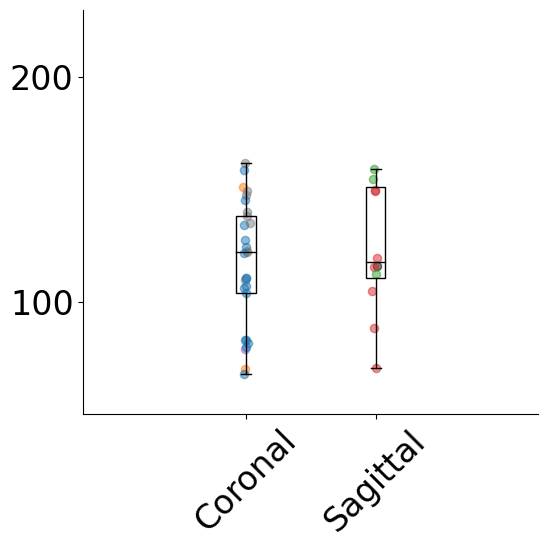

In [ ]:
# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
# use only pulse 1 data and exclude is_single_pulse_control = 1

all_barrel_df['Detailed_Section'] = all_barrel_df['Detailed_Section'].astype('category')
all_barrel_df['Section'] = all_barrel_df['Section'].astype('category')

# font size
plt.rcParams.update({'font.size': 24})

sections = ['Coronal', 'Sagittal']
section_colors = {
    'Coronal': 'tab:blue',
    'Sagittal': 'red',
}
outlier_lim = 700

# don't use seaborn, use matplotlib
# and plot only positive values

grouped_dfs = {}

for metric in ['instantaneous_velocity', ]:
    plt.figure(figsize=(6, 6))

    handles = []
    for barrel_type in ladder_df['Detailed_Section'].cat.categories:
        # filter for positive values
        section = 'Coronal' if barrel_type.endswith("AC") else 'Sagittal'
        df = ladder_df.copy()
        df = df[df['Detailed_Section'] == barrel_type]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        if metric == 'instantaneous_velocity':
            # outliers 
            df = df[(df[metric] < outlier_lim)] 
        
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = det_dir_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + sections.index(section) 

        # scatter and jitter the data points
        jittered_x = np.random.normal(x_space, 0.01, size=len(df[metric]))
        l1 = plt.scatter(jittered_x, df[metric], color=color, alpha=0.5, s=35, label=barrel_type)
        #l1 = plt.bar(x_space, df[metric].mean(), color=color, alpha=0.5, width=0.1, label=barrel_type)
        handles.append(l1)

        #plt.errorbar(x_space, df[metric].mean(), yerr=sem(df[metric]), fmt='o', color=color, capsize=5, markersize=5)
    for section in all_barrel_df['Section'].cat.categories:

        df = ladder_df.copy()
        df = df[df['Section'] == section]
        # if halfwidth, only positive values. If latency, only positive values < 20
        if metric == 'latency':
            df = df[df[metric] < 20]
        if metric == 'instantaneous_velocity':
            # outliers 
            df = df[(df[metric] < outlier_lim)]  
        df = df[df[metric] > 0]

        # group by date, slice, and location
        df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()

        color = box_colors.get(barrel_type, 'black')  # default to black if not found

        x_space = 1 + sections.index(section) 

        # boxplot the data points
        plt.boxplot(df[metric], positions=[x_space], 
                    patch_artist=True, boxprops=dict(facecolor='none', color=color), 
                    medianprops=dict(color=color), showfliers=False)

        # print the mean and sem for each group
        print(f"{section} {metric}: {df[metric].mean():.2f} ± {sem(df[metric]):.2f}")
        # and sample size after grouping by date, slice, location
        df_grouped = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
        print(f"Sample size {section}: {len(df_grouped)}")

        if metric not in grouped_dfs:
            grouped_dfs[metric] = {}
        grouped_dfs[metric][section] = df_grouped
    
    df = ladder_df.copy()
    df = df[(df[metric] < outlier_lim)]  
    df = df[df[metric] > 0]
    #filter nan
    df = df[df[metric].notna()]
    df = df.groupby(['Date', 'Slice', 'Location']).mean().reset_index()
    print(f"Overal {metric}: {df[metric].mean():.2f} ± {sem(df[metric]):.2f}")

    # significance testing
    next_bar = 0
    section_t = all_barrel_df['Section'].cat.categories
    for i1 in range(len(section_t)):
        barrel_type1 = section_t[i1]
        for i2 in range(i1 + 1, len(section_t)):
            barrel_type2 = section_t[i2]
            df1 = grouped_dfs[metric][barrel_type1]
            df2 = grouped_dfs[metric][barrel_type2]
            ttest_result = ttest_ind(df1[metric], df2[metric], equal_var=False)
            if ttest_result.pvalue < 0.05:
                print(f"Significant difference in {metric} between {barrel_type1} and {barrel_type2}: p = {ttest_result.pvalue:.4f}")
                print("T-test results:")
                print(f"t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")

                # add p < 0.05 label to the plot above the bars
                y_space = max(df1[metric].mean(), df2[metric].mean()) + 75 + next_bar
                x_space1 = 1 + sections.index(barrel_type1)
                x_space2 = 1 + sections.index(barrel_type2)
                plt.text((x_space1 + x_space2 ) / 2, y_space+30, f"p < 0.05", ha='center', va='bottom', fontsize=22, color='black')

                # add a line between the two bars
                plt.plot([x_space1, x_space2], [y_space * 1.1, y_space * 1.1], color='black', linewidth=2)

                # add caps on ends of line
                plt.plot([x_space1, x_space1], [y_space * 1.1, y_space * 0.995], color='black', linewidth=2)
                plt.plot([x_space2, x_space2], [y_space * 1.1, y_space * 0.995], color='black', linewidth=2)
                next_bar += 1
            else:
                print(f"No significant difference in {metric} between {barrel_type1} and {barrel_type2}: t-statistic: {ttest_result.statistic:.4f}, p = {ttest_result.pvalue:.4f}")
    # mean +/- sem over all velocities
    

    if metric == 'halfwidth':
        # place the legend to the left of the plot
        plt.yticks([0, 10, 20,  30], fontsize=40)
        plt.ylim(0, 30)
        plt.ylabel('Half-width (ms)', fontsize=40, labelpad=20)
    elif metric == 'latency':
        plt.legend(handles=handles, loc='lower left', fontsize=22, ncol=2)

        plt.ylabel('Latency (ms)', fontsize=40, labelpad=20)
        plt.yticks([0, 2, 4, 6, 8], fontsize=40)
        plt.ylim(0, 8)
    elif metric == 'instantaneous_velocity':
        #plt.ylabel(r'Within-Barrel Speed ($\mu$m/ms)', fontsize=40, labelpad=20)
        plt.yticks([0,  100,  200], fontsize=24)
        plt.ylim(50, 230)
    
    plt.xticks([i for i in range(1,3)], sections, fontsize=24, rotation=45)
    #plt.xticks([0.25, 0.5, 0.75, 1], ['Rostral', 'Caudal', 'Medial', 'Lateral'], fontsize=24)
    plt.xlim(-.25, 3.25)
    plt.tight_layout()


    # set spines to be invisible
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.savefig(output_fig_dir + 'coronal_sagittal_barrels_' + metric + '.png', dpi=300, bbox_inches='tight')
    plt.show()



In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrix
from scipy.stats import t, ttest_ind

# Example dataset
ppr = [.58, .73, .85, .73]
n_ppr = [7, 8, 8, 11]
ppr_sem = [.08, 0.06, .06, .12]

barrel_types = []
pprs = []
for i, barr_ty in enumerate(['Ventral', 'Dorsal', 'Rostral', 'Caudal']):
    barrel_types.extend([barr_ty] * n_ppr[i])
    pprs.extend(np.random.normal(ppr[i], ppr_sem[i], n_ppr[i]))
ppr_df = pd.DataFrame({'Barrel_Type': barrel_types, 'PPR': pprs})

# List of metrics — only PPR here, but others could be added
for metric in ['instantaneous_velocity', 'latency', 'halfwidth', 'PPR']: #, 'amp_ratio']:
    df = ladder_df.copy()
    df = df.groupby(['Date', 'Slice', 'Location', 'Barrel_Type']).mean().reset_index()
    if metric == 'latency' or metric == 'halfwidth':
        df = all_barrel_df.copy()    
        df = df[df[metric] > 0]
        df = df.groupby(['Date', 'Slice', 'Location', 'Barrel_Type']).mean().reset_index()
    if metric == 'PPR':
        df = ppr_df.copy()

    df = df[df['Barrel_Type'].notna()]
    df = df[df[metric].notna()]

    # average over Date, Slice, Location
    #print(df)
    # Drop NaNs and invalid entries


    df = df[df[metric] > 0]

    # Set categorical order
    df['Barrel_Type'] = pd.Categorical(
        df['Barrel_Type'], 
        categories=['Dorsal', 'Ventral',  'Rostral', 'Caudal']
    )

    #  sum contrasts
    X = dmatrix('C(Barrel_Type, Sum)', data=df, return_type='dataframe')
    y = df[metric]

    # Fit OLS model
    model = sm.OLS(y, X).fit()

    print("\n\n", metric, df.shape)
    #print(model.summary())

    # Extract parameters and covariance
    params = model.params.values
    cov = model.cov_params().values
    df_resid = model.df_resid

    # Define reference-invariant contrast
    # (Ventral + Rostral) < (Dorsal + Caudal)
    # The first column is the intercept (grand mean), the rest are deviations
    # The number/order of deviation columns depends on patsy but is consistent
    coef_names = X.design_info.column_names
    print("Design columns:", coef_names)

    # Build a contrast that corresponds to:
    # Protraction <  Retraction
    # (Dorsal + Rostral) < (Ventral + Caudal)
    L = np.zeros(len(coef_names))

    for i, name in enumerate(coef_names):
        if 'Ventral' in name:
            L[i] = 1
        elif 'Rostral' in name:
            L[i] = -1
        elif 'Dorsal' in name:
            L[i] = -1
        elif 'Caudal' in name:
            L[i] = 1

    # flip for some metrics
    if metric == 'PPR' or metric == 'latency' or metric == 'instantaneous_velocity':
        L = -L

    # Compute contrast
    contrast_value = L @ params
    contrast_se = np.sqrt(L @ cov @ L)
    t_stat = contrast_value / contrast_se
    p_val = 1 - t.cdf(t_stat, df_resid)

    print(f"Contrast: (Ventral + Caudal) > (Dorsal + Rostral)")
    print(f"t = {t_stat:.3f}, df = {df_resid:.0f}, p (one-sided) = {p_val:.4f}")





 instantaneous_velocity (40, 18)
Design columns: ['Intercept', 'C(Barrel_Type, Sum)[S.Dorsal]', 'C(Barrel_Type, Sum)[S.Ventral]', 'C(Barrel_Type, Sum)[S.Rostral]']
Contrast: (Ventral + Caudal) > (Dorsal + Rostral)
t = 0.117, df = 36, p (one-sided) = 0.4539


 latency (36, 22)
Design columns: ['Intercept', 'C(Barrel_Type, Sum)[S.Dorsal]', 'C(Barrel_Type, Sum)[S.Ventral]', 'C(Barrel_Type, Sum)[S.Rostral]']
Contrast: (Ventral + Caudal) > (Dorsal + Rostral)
t = 0.631, df = 32, p (one-sided) = 0.2662


 halfwidth (36, 22)
Design columns: ['Intercept', 'C(Barrel_Type, Sum)[S.Dorsal]', 'C(Barrel_Type, Sum)[S.Ventral]', 'C(Barrel_Type, Sum)[S.Rostral]']
Contrast: (Ventral + Caudal) > (Dorsal + Rostral)
t = 1.019, df = 32, p (one-sided) = 0.1580


 PPR (34, 2)
Design columns: ['Intercept', 'C(Barrel_Type, Sum)[S.Dorsal]', 'C(Barrel_Type, Sum)[S.Ventral]', 'C(Barrel_Type, Sum)[S.Rostral]']
Contrast: (Ventral + Caudal) > (Dorsal + Rostral)
t = 5.252, df = 30, p (one-sided) = 0.0000


In [ ]:
# replace Rostral/Caudal column name with Rostral_Caudal and Medial/Lateral with Medial_Lateral
ppr_df.rename(columns={'Rostral/Caudal': 'Rostral_Caudal', 'Medial/Lateral': 'Medial_Lateral'}, inplace=True)
ppr_df.columns

Index(['Barrel_Type', 'PPR'], dtype='object')

In [ ]:
'''# 2-way ANOVA for rostral and caudal PPR vs IPI (sagittal sections)
model = ols('PPR ~ IPI + C(Rostral_Caudal) + IPI:C(Rostral_Caudal)', 
                data=ppr_df[(ppr_df['Rostral_Caudal'] != 'Home') & (ppr_df['Section'] == 'Sagittal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table'''

"# 2-way ANOVA for rostral and caudal PPR vs IPI (sagittal sections)\nmodel = ols('PPR ~ IPI + C(Rostral_Caudal) + IPI:C(Rostral_Caudal)', \n                data=ppr_df[(ppr_df['Rostral_Caudal'] != 'Home') & (ppr_df['Section'] == 'Sagittal')]).fit()\nanova_table = anova_lm(model, typ=2)\nanova_table"

In [ ]:
'''# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)
model = ols('PPR ~ IPI + C(Section) + IPI:C(Section)', 
                data=ppr_df[(ppr_df['Medial_Lateral'] != 'Home') & (ppr_df['Rostral_Caudal'] != 'Home')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table'''

"# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)\nmodel = ols('PPR ~ IPI + C(Section) + IPI:C(Section)', \n                data=ppr_df[(ppr_df['Medial_Lateral'] != 'Home') & (ppr_df['Rostral_Caudal'] != 'Home')]).fit()\nanova_table = anova_lm(model, typ=2)\nanova_table"

In [ ]:
'''# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)
model = ols('PPR ~ C(Section)', 
                data=ppr_df[(ppr_df['IPI'] == 10)]).fit()
anova_table = anova_lm(model, typ=2)
anova_table'''

"# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)\nmodel = ols('PPR ~ C(Section)', \n                data=ppr_df[(ppr_df['IPI'] == 10)]).fit()\nanova_table = anova_lm(model, typ=2)\nanova_table"

In [ ]:
# post-hoc power analysis: PPR
import numpy as np
from statsmodels.stats.power import TTestIndPower
power_analysis = TTestIndPower()
# Calculate the effect size
ppr = [.62, .75, .85, .78]
n_ppr = [7, 8, 8, 11]
ppr_sem = [.08, 0.06, .06, .12]
ppr_std = [ppr_sem[i] * np.sqrt(n_ppr[i]) for i in range(len(ppr_sem))]

ppr_mean_diffs = []
for i in range(len(ppr) - 1):
    for j in range(i + 1, len(ppr)):
        # calculate the mean difference between the two groups
        mean_diff = abs(ppr[i] - ppr[j])
        ppr_mean_diffs.append(mean_diff)

# caculate effect size
ppr_effect_size = np.mean(ppr_mean_diffs) / np.mean(ppr_std)
power = power_analysis.solve_power(effect_size=ppr_effect_size, nobs1=np.max(n_ppr), alpha=0.05, power=None, alternative='two-sided')
print(f"Effect size: {ppr_effect_size:.2f}, Power: {power:.2f}")

Effect size: 0.51, Power: 0.20


In [ ]:
# post-hoc power analysis: latency
# We report latency of neighbor barrels in each of four directions (caudal: 6.2 ± 0.2 ms; rostral: 5.8 ± 0.4; medial: 6.1 ± 0.3; lateral: 5.9 ± 0.3).   
latency = [6.2, 5.8, 6.1, 5.9]
n_latency = [7, 8, 8, 11]
latency_sem = [0.2, 0.4, 0.3, 0.3]
latency_std = [latency_sem[i] * np.sqrt(n_latency[i]) for i in range(len(latency_sem))]
latency_mean_diffs = []
for i in range(len(latency) - 1):
    for j in range(i + 1, len(latency)):
        # calculate the mean difference between the two groups
        mean_diff = abs(latency[i] - latency[j])
        latency_mean_diffs.append(mean_diff)
# caculate effect size
latency_effect_size = np.mean(latency_mean_diffs) / np.mean(latency_std)
power = power_analysis.solve_power(effect_size=latency_effect_size, nobs1=np.max(n_latency), alpha=0.05, power=None, alternative='two-sided')
print(f"Effect size: {latency_effect_size:.2f}, Power: {power:.2f}")

Effect size: 0.27, Power: 0.09


In [ ]:
# post-hoc power analysis: halfwidth
# caudal: 14.6 ± 1.3 ms; rostral: 13.5 ± 1.6 ms; dorsal: 14.0 ± 1.3 ms;  ventral: 15.5 ± 1.3 ms
halfwidth = [14.6, 13.5, 14.0, 15.5]
n_halfwidth = [7, 8, 8, 11]
halfwidth_sem = [1.3, 1.6, 1.3, 1.3]
halfwidth_std = [halfwidth_sem[i] * np.sqrt(n_halfwidth[i]) for i in range(len(halfwidth_sem))]
halfwidth_mean_diffs = []
for i in range(len(halfwidth) - 1):
    for j in range(i + 1, len(halfwidth)):
        # calculate the mean difference between the two groups
        mean_diff = abs(halfwidth[i] - halfwidth[j])
        halfwidth_mean_diffs.append(mean_diff)
# caculate effect size
halfwidth_effect_size = np.mean(halfwidth_mean_diffs) / np.mean(halfwidth_std)
power = power_analysis.solve_power(effect_size=halfwidth_effect_size, nobs1=np.max(n_halfwidth), alpha=0.05, power=None, alternative='two-sided')
print(f"Effect size: {halfwidth_effect_size:.2f}, Power: {power:.2f}")

Effect size: 0.28, Power: 0.09


In [ ]:
# post-hoc power analysis: velocity
# ventral: 130 ± 6 µm/ms, n = 19; caudal: 154 ± 15 µm/ms, n = 9, dorsal: 125 ± 14 µm/ms, n = 4; rostral: 185 ± 9 µm/ms, n = 3). 
velocity = [130, 154, 125, 185]
n_velocity = [19, 9, 4, 3]
velocity_sem = [6, 15, 14, 9]
velocity_std = [velocity_sem[i] * np.sqrt(n_velocity[i]) for i in range
(len(velocity_sem))]
velocity_mean_diffs = []
for i in range(len(velocity) - 1):
    for j in range(i + 1, len(velocity)):
        # calculate the mean difference between the two groups
        mean_diff = abs(velocity[i] - velocity[j])
        velocity_mean_diffs.append(mean_diff)
# caculate effect size
velocity_effect_size = np.mean(velocity_mean_diffs) / np.mean(velocity_std)
power = power_analysis.solve_power(effect_size=velocity_effect_size, nobs1=np.max(n_velocity), alpha=0.05, power=None, alternative='two-sided')
print(f"Effect size: {velocity_effect_size:.2f}, Power: {power:.2f}")

Effect size: 1.19, Power: 0.94


In [ ]:
# post-hoc power analysis: contrast model (ventral - dorsal + rostral - caudal)
power_analysis = TTestIndPower()
# Calculate the effect size: velocity contrast (Ventral - Dorsal + Rostral - Caudal)
contrast_effect_size = np.abs((velocity[0] - velocity[2]) + (velocity[3] - velocity[1])) / np.mean(velocity_std)
power = power_analysis.solve_power(effect_size=contrast_effect_size, nobs1=np.sum(n_velocity[:2]), alpha=0.05, power=None, alternative='larger')
print(f"Velocity contrast effect size: {contrast_effect_size:.2f}, Power: {power:.2f}")
# Calculate the effect size: latency contrast (Ventral - Dorsal + Rostral - Caudal)
contrast_effect_size = np.abs((latency[0] - latency[2]) + (latency[3] - latency[1])) / np.mean(latency_std)
power = power_analysis.solve_power(effect_size=contrast_effect_size, nobs1=np.sum(n_latency[:2]), alpha=0.05, power=None, alternative='larger')
print(f"Latency contrast effect size: {contrast_effect_size:.2f}, Power: {power:.2f}")
# Calculate the effect size: halfwidth contrast (Ventral - Dorsal + Rostral - Caudal)
contrast_effect_size = np.abs((halfwidth[0] - halfwidth[2]) + (halfwidth[3] - halfwidth[1])) / np.mean(halfwidth_std)
power = power_analysis.solve_power(effect_size=contrast_effect_size, nobs1=np.sum(n_halfwidth[:2]), alpha=0.05, power=None, alternative='larger')
print(f"Halfwidth contrast effect size: {contrast_effect_size:.2f}, Power: {power:.2f}")
# calculate the effect size: PPR contrast (Ventral - Dorsal + Rostral - Caudal)
contrast_effect_size = np.abs((ppr[0] - ppr[2]) + (ppr[3] - ppr[1])) / np.mean(ppr_std)
power = power_analysis.solve_power(effect_size=contrast_effect_size, nobs1=np.sum(n_ppr[:2]), alpha=0.05, power=None, alternative='larger')
print(f"PPR contrast effect size: {contrast_effect_size:.2f}, Power: {power:.2f}")

Velocity contrast effect size: 1.25, Power: 1.00
Latency contrast effect size: 0.23, Power: 0.15
Halfwidth contrast effect size: 0.65, Power: 0.54
PPR contrast effect size: 0.84, Power: 0.73


In [ ]:
# compare the supra data (supra_df) to the L4 data (hw_lat_df):
#       for ACSF and NBQX, and for L2/3 and L4 stim, and for home versus neighbor
# leave out Medial/Lateral comparison for now
# do latency, half-width, amplitude, comparing supra to L4, for all four of the following plots:
#  - plot 1 home barrel in L4 stim: ACSF vs NBQX
#  - plot 2 neighbor barrel in L4 stim: ACSF vs NBQX
#  - plot 3 home barrel in L2/3 stim: ACSF vs NBQX
#  - plot 4 neighbor barrel in L2/3 stim: ACSF vs NBQX

from scipy.stats import ttest_1samp


# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/"
ppr_coronal_df = data_dir + "export_summary_backup_coronal.csv"
ppr_sagittal_df = data_dir + "export_summary_backup_sagittal.csv"

camera_program = 4
um_per_px = 6.0 #um

# load the CSVs
ppr_coronal_df = pd.read_csv(ppr_coronal_df)
ppr_sagittal_df = pd.read_csv(ppr_sagittal_df)

# add column for Coronal/Sagittal
ppr_coronal_df['Section'] = 'Coronal'
ppr_sagittal_df['Section'] = 'Sagittal'

# combine the dataframes
ppr_df = ppr_coronal_df.append(ppr_sagittal_df)
output_fig_dir = 'P:/John/crossing-paper/input/'
ppr_df

# load PPR catalog
ppr_catalog = data_dir + "ppr_catalog_backup-both.csv"
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and is_single_pulse_control columns
#ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'is_single_pulse_control']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}/{d}/20{y}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)
ppr_catalog_df
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

# merge the two dataframes, using date, slice, location, and recording as keys
ppr_df = ppr_df.merge(ppr_catalog_df, on=['Date', 'Slice', 'Location', 'Recording'])

# drop the zda_file column
ppr_df.drop('zda_file', axis=1, inplace=True)

ppr_df

# hw, lat, and amp between rostral and caudal barrels (Sagittal), medial and lateral barrels (Coronal), and coronal and sagittal sections
ppr_df = ppr_df[ppr_df['is_single_pulse_control'] == 1]
ppr_df = ppr_df[ppr_df['ROI_Set'].str.contains('pulse1')]


# barplot of hw, lat, and amp for rostral, caudal, medial, and lateral barrels

barrel_df = ppr_df.copy()
# read in hw/lat/amp data
data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
hw_lat_data = data_dir + 'export_summary_hw_latency_amp.csv'
hw_lat_df = pd.read_csv(hw_lat_data)
hw_lat_df['latency'] -= 48.6
hw_lat_df

nbqx_export_sagittal = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/sagittal_L4_NBQX/' + "export_summary_backup.csv"
hw_lat_sagittal_df = pd.read_csv(nbqx_export_sagittal)
hw_lat_sagittal_df
hw_lat_df['Section'] = 'Coronal'
hw_lat_sagittal_df['Section'] = 'Sagittal'

# merge the two hw_lat dataframes
hw_lat_df = pd.concat([hw_lat_df, hw_lat_sagittal_df], ignore_index=True)

# only need drug == "ACSF"
hw_lat_df = hw_lat_df[hw_lat_df['drug'] == 'ACSF']

# only keep dates that are not already in barrel_df
hw_lat_df = hw_lat_df[~hw_lat_df['Date'].isin(barrel_df['Date'].unique())]

# only keep L4 in Layer column and ROI > 1
hw_lat_df = hw_lat_df[(hw_lat_df['Layer'] == 'L4') & (hw_lat_df['ROI'] > 1)]
hw_lat_df

# concat barrel_df and hw_lat_df and name it all_barrel_df
all_barrel_df = pd.concat([barrel_df, hw_lat_df], ignore_index=True)

all_barrel_df.loc[all_barrel_df['Section'] == 'Sagittal', 'Barrel_Type'] = all_barrel_df[all_barrel_df['Section'] == 'Sagittal']['Rostral/Caudal']
all_barrel_df.loc[all_barrel_df['Section'] == 'Coronal', 'Barrel_Type'] = all_barrel_df[all_barrel_df['Section'] == 'Coronal']['Medial/Lateral']

for df in [all_barrel_df]:
    # add new column 'Detailed_Section', empty
    df['Detailed_Section'] = ''

    # in barrel_df['Crossing_Direction'], convert Lateral to Ventral and Medial to Dorsal
    df['Barrel_Type'] = df['Barrel_Type'].replace({'Lateral': 'Ventral', 'Medial': 'Dorsal'})

    # fill 'Detailed_Section' based on 'Section' and 'Relationship_to_home' in barrel_relation_df
    for i, row in df.iterrows():
        # look up the section and relationship in barrel_relation_df, matching on Date, Slice, Loc
        date = row['Date']
        slice_id, loc_id = int(row['Slice']), int(row['Location'])
        slice_id = int(slice_id)
        loc_id = int(loc_id)
        
        barrel_rel_row = barrel_relation_df[(barrel_relation_df['Date'] == date) & 
                                        (barrel_relation_df['Slice'] == slice_id) & 
                                        (barrel_relation_df['ROI'] > 1)]
        
        if barrel_rel_row.empty:
            print(f"No matching barrel relationship found for Date: {date}, Slice: {slice_id}, Loc: {loc_id}")
            print("unique dates in barrel_relation_df:", barrel_relation_df['Date'].unique())
            continue
        section = barrel_rel_row['Section'].values[0]
        relationship = barrel_rel_row['Relationship_to_home'].values[0]
        
        if section == 'Coronal':
            if relationship == 'rostral row':
                df.at[i, 'Detailed_Section'] = 'RAC'
            else:
                df.at[i, 'Detailed_Section'] = 'CAC'
        elif section == 'Sagittal':
            df.at[i, 'Detailed_Section'] = 'VAS'

    # concat Barrel_Type to the front of 'Detailed_Section'
    df['Detailed_Section'] = df['Barrel_Type'] + ' ' + df['Detailed_Section']
    print(df['Detailed_Section'].unique())

    # print the number of unique dates in all_barrel_df and ladder_df where Detailed_Section is not empty
    print("Unique dates in df with Detailed_Section:", len(df[df['Detailed_Section'].notna()]['Date'].unique()))


No matching barrel relationship found for Date: 1/22/2025, Slice: 3, Loc: 2
unique dates in barrel_relation_df: ['6/26/2024' '7/1/2024' '7/15/2024' '7/17/2024' '11/6/2024' '12/9/2024'
 '12/11/2024' '10/23/2024' '10/29/2024' '12/18/2024' '12/20/2024'
 '1/2/2025' '1/7/2025' '12/23/2024' '1/15/2025' '1/22/2025' '2/5/2025'
 '4/9/2025' '4/16/2025' nan]
No matching barrel relationship found for Date: 1/22/2025, Slice: 3, Loc: 2
unique dates in barrel_relation_df: ['6/26/2024' '7/1/2024' '7/15/2024' '7/17/2024' '11/6/2024' '12/9/2024'
 '12/11/2024' '10/23/2024' '10/29/2024' '12/18/2024' '12/20/2024'
 '1/2/2025' '1/7/2025' '12/23/2024' '1/15/2025' '1/22/2025' '2/5/2025'
 '4/9/2025' '4/16/2025' nan]
No matching barrel relationship found for Date: 1/22/2025, Slice: 3, Loc: 2
unique dates in barrel_relation_df: ['6/26/2024' '7/1/2024' '7/15/2024' '7/17/2024' '11/6/2024' '12/9/2024'
 '12/11/2024' '10/23/2024' '10/29/2024' '12/18/2024' '12/20/2024'
 '1/2/2025' '1/7/2025' '12/23/2024' '1/15/2025' '1

In [ ]:
# new column in all_barrel_df called 'neighbor_home_amp_ratio' which is amplitude of ROI 2 divided by amplitude of ROI 1 for each date, slice, location, recording
neighbor_home_amp_ratios = {'Ventral': [], 'Dorsal': [], 'Rostral': [], 'Caudal': []}
number_potential_ratios = {'Ventral': 0, 'Dorsal': 0, 'Rostral': 0, 'Caudal': 0}
all_barrel_df['neighbor_home_amp_ratio'] = np.nan
for date in all_barrel_df['Date'].unique():
    date_df = all_barrel_df[all_barrel_df['Date'] == date]
    for slice_num in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slice_num]
        for location in slice_df['Location'].unique():
            location_df = slice_df[slice_df['Location'] == location]
            # group by date, slice, and location, averaging over multiple recordings
            # first filter out to amp > 0
            location_df = location_df[location_df['amp'] > 0]
            df_subset = location_df.groupby(['Date', 'Slice', 'Location', 'ROI', 'Barrel_Type']).mean().reset_index()
            if len(df_subset) >= 2:
                amp_roi1 = df_subset[df_subset['ROI'] == 1]['amp'].values
                amp_roi2 = df_subset[df_subset['ROI'] > 1]['amp'].values
                barrel_types = df_subset[df_subset['ROI'] > 1]['Barrel_Type'].values
                for i, barrel_type in enumerate(barrel_types):
                    if barrel_type == 'Home':
                        print(df_subset)
                    neighbor_amp = amp_roi2[i]
                    number_potential_ratios[barrel_type] += 1
                    if len(amp_roi1) > 0 and len(amp_roi2) > 0:
                        ratio = neighbor_amp / amp_roi1[0]
                        print(f"Date: {date}, Slice: {slice_num}, Location: {location}, "
                                f" ROI1 Amp: {amp_roi1}, ROI2 Amp: {neighbor_amp}, Barrel Type: {barrel_type}")

                        if ratio < 0:
                            ratio = np.nan
                        else:
                            print(ratio)
                            neighbor_home_amp_ratios[barrel_type].append(ratio)
for k in neighbor_home_amp_ratios:
    print(len(neighbor_home_amp_ratios[k]), np.nanmean(neighbor_home_amp_ratios[k]), sem(neighbor_home_amp_ratios[k], nan_policy='omit'))
for k in number_potential_ratios:
    print(f"Number of potential ratios for {k}: {number_potential_ratios[k]}")

Date: 1/2/2025, Slice: 1, Location: 3,  ROI1 Amp: [0.32258387], ROI2 Amp: 0.24416017499999998, Barrel Type: Ventral
0.7568889694818198
Date: 1/2/2025, Slice: 2, Location: 2,  ROI1 Amp: [9.97795077], ROI2 Amp: 2.5800838461538467, Barrel Type: Dorsal
0.2585785303842256
Date: 1/7/2025, Slice: 1, Location: 2,  ROI1 Amp: [4.49722077], ROI2 Amp: 1.9260669230769227, Barrel Type: Ventral
0.4282793800684079
Date: 1/7/2025, Slice: 2, Location: 5,  ROI1 Amp: [4.66828692], ROI2 Amp: 3.068148461538461, Barrel Type: Ventral
0.6572321950417325
Date: 1/7/2025, Slice: 3, Location: 2,  ROI1 Amp: [9.46145625], ROI2 Amp: 1.7866760000000002, Barrel Type: Dorsal
0.1888373156087891
Date: 1/7/2025, Slice: 3, Location: 2,  ROI1 Amp: [9.46145625], ROI2 Amp: 1.3574824615384615, Barrel Type: Ventral
0.14347500275535932
Date: 1/7/2025, Slice: 4, Location: 2,  ROI1 Amp: [21.28839385], ROI2 Amp: 3.858983846153846, Barrel Type: Ventral
0.18127172364631186
Date: 11/6/2024, Slice: 2, Location: 1,  ROI1 Amp: [2.0999611]

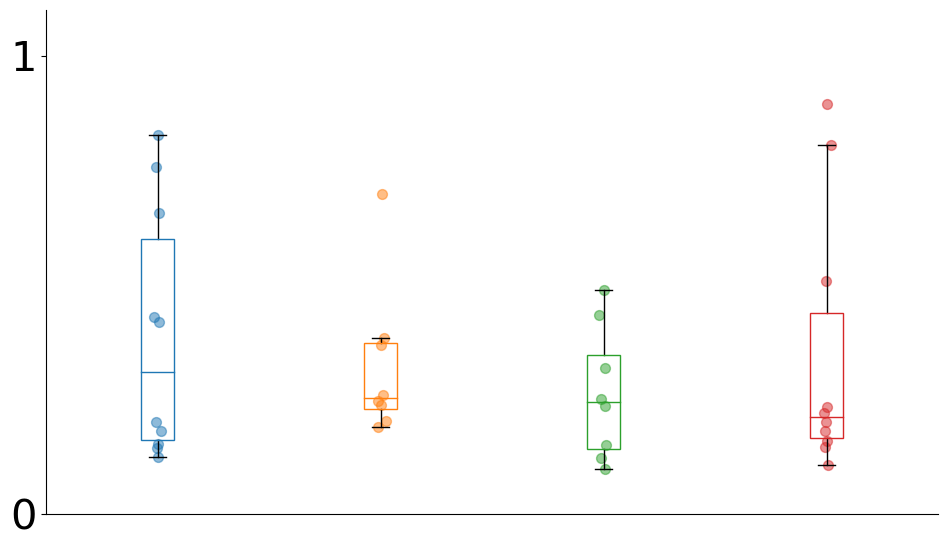

In [ ]:
barrel_types = ['Ventral', 'Dorsal', 'Rostral', 'Caudal']
box_colors = {
    'Ventral': 'tab:blue',
    'Dorsal': 'tab:orange',
    'Rostral': 'tab:green',
    'Caudal': 'tab:red',}
plt.figure(figsize=(10, 6))
for i, barrel_type in enumerate(barrel_types):


    # scatter and jitter the data points
    data = neighbor_home_amp_ratios[barrel_type]

    jittered_x = np.random.normal(i, 0.01, size=len(data))
    l1 = plt.scatter(jittered_x, data, color=box_colors[barrel_type], alpha=0.5, s=50, label=barrel_type)

    # boxplot the data points
    plt.boxplot(data, positions=[i], 
                patch_artist=True, boxprops=dict(facecolor='none', color=box_colors[barrel_type]), 
                medianprops=dict(color=box_colors[barrel_type]), showfliers=False)

#plt.ylabel('Neighbor/Home ΔF/F Ratio', fontsize=24)  
plt.xticks([])
plt.yticks([0, 1], fontsize=30)
# spines off
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlim(-0.5, -0.5 + len(barrel_types))
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig(output_fig_dir + 'neighbor_home_amp_ratio_' + barrel_type + '.png', dpi=300, bbox_inches='tight')
plt.show()



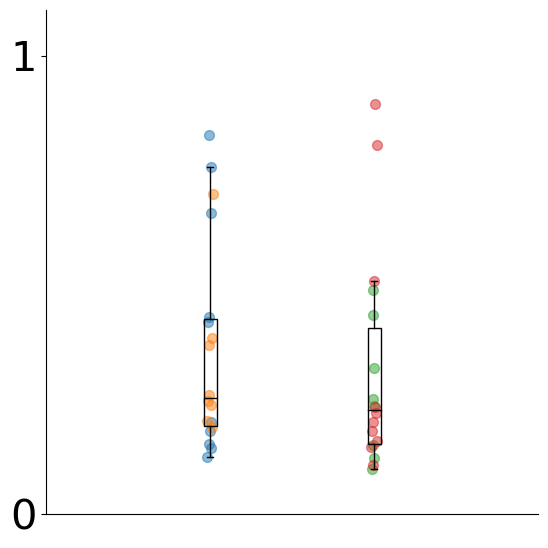

T-test between coronal and sagittal neighbor/home amp ratios: t-statistic: 0.6683, p-value: 0.5084
Coronal neighbor/home amp ratio: 0.36 ± 0.05, n = 18
Sagittal neighbor/home amp ratio: 0.31 ± 0.05, n = 18
Ventral neighbor/home amp ratio: 0.39 ± 0.09, n = 10
Dorsal neighbor/home amp ratio: 0.32 ± 0.06, n = 8
Rostral neighbor/home amp ratio: 0.26 ± 0.05, n = 8
Caudal neighbor/home amp ratio: 0.35 ± 0.09, n = 10


In [ ]:
# now do coronal vs sagittal comparison for neighbor/home amp ratio
coronal_ratios = neighbor_home_amp_ratios['Dorsal'] + neighbor_home_amp_ratios['Ventral']
sagittal_ratios = neighbor_home_amp_ratios['Rostral'] + neighbor_home_amp_ratios['Caudal']

plt.figure(figsize=(6, 6))
for i, barrel_type in enumerate(barrel_types):
    j = 0 if barrel_type in ['Dorsal', 'Ventral'] else 1

    # scatter and jitter the data points
    data = neighbor_home_amp_ratios[barrel_type]

    jittered_x = np.random.normal(j, 0.01, size=len(data))
    l1 = plt.scatter(jittered_x, data, color=box_colors[barrel_type], alpha=0.5, s=50, label=barrel_type)

# boxplot for coronal and sagittal
plt.boxplot(coronal_ratios, positions=[0], 
            patch_artist=True, boxprops=dict(facecolor='none', color='black'), 
            medianprops=dict(color='black'), showfliers=False, widths=0.08)
plt.boxplot(sagittal_ratios, positions=[1], 
            patch_artist=True, boxprops=dict(facecolor='none', color='black'), 
            medianprops=dict(color='black'), showfliers=False, widths=0.08)

plt.xticks([])
plt.yticks([0, 1], fontsize=30)
# spines off
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-1, 2)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig(output_fig_dir + 'neighbor_home_amp_ratio_coronal_vs_sagittal.png', dpi=300, bbox_inches='tight')
plt.show()

# t-test between coronal and sagittal ratios
ttest_result = ttest_ind(coronal_ratios, sagittal_ratios, equal_var=False)
print(f"T-test between coronal and sagittal neighbor/home amp ratios: t-statistic: {ttest_result.statistic:.4f}, p-value: {ttest_result.pvalue:.4f}")

# mean / sem measurements for coronal and sagittal neighbor/home amp ratios
print(f"Coronal neighbor/home amp ratio: {np.mean(coronal_ratios):.2f} ± {sem(coronal_ratios):.2f}, n = {len(coronal_ratios)}")
print(f"Sagittal neighbor/home amp ratio: {np.mean(sagittal_ratios):.2f} ± {sem(sagittal_ratios):.2f}, n = {len(sagittal_ratios)}")

# mean / sem measurements for each barrel type
for barrel_type in barrel_types:
    data = neighbor_home_amp_ratios[barrel_type]
    print(f"{barrel_type} neighbor/home amp ratio: {np.mean(data):.2f} ± {sem(data):.2f}, n = {len(data)}")

In [ ]:

from scipy.stats import ttest_ind
# anova between barrel types
# create an anova_df that has columns 'Barrel_Type' and 'neighbor_home_amp_ratio'
barrel_types = []
amp_ratios = []
for bt in neighbor_home_amp_ratios:
    barrel_types.extend([bt] * len(neighbor_home_amp_ratios[bt]))
    amp_ratios.extend(neighbor_home_amp_ratios[bt])
anova_df = pd.DataFrame({'Barrel_Type': barrel_types,
                          'neighbor_home_amp_ratio': amp_ratios})
anova_df['Barrel_Type'] = anova_df['Barrel_Type'].astype('category')
model = ols(f"neighbor_home_amp_ratio ~ C(Barrel_Type)", data=anova_df).fit()
anova_results = anova_lm(model, typ=2)
print(f"\n\nANOVA results for neighbor_home_amp_ratio:")
print(anova_results)




ANOVA results for neighbor_home_amp_ratio:
                  sum_sq    df         F    PR(>F)
C(Barrel_Type)  0.074043   3.0  0.449682  0.719257
Residual        1.756327  32.0       NaN       NaN


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrix
from scipy.stats import t, ttest_ind



# List of metrics — only PPR here, but others could be added
for metric in ['neighbor_home_amp_ratio']:
    df = anova_df.copy()

    # average over Date, Slice, Location
    #print(df)
    # Drop NaNs and invalid entries


    df = df[df[metric] > 0]

    # Set categorical order
    df['Barrel_Type'] = pd.Categorical(
        df['Barrel_Type'], 
        categories=['Dorsal', 'Ventral',  'Rostral', 'Caudal']
    )

    #  sum contrasts
    X = dmatrix('C(Barrel_Type, Sum)', data=df, return_type='dataframe')
    y = df[metric]

    # Fit OLS model
    model = sm.OLS(y, X).fit()

    print("\n\n", metric, df.shape)
    #print(model.summary())

    # Extract parameters and covariance
    params = model.params.values
    cov = model.cov_params().values
    df_resid = model.df_resid

    # Define reference-invariant contrast
    # (Ventral + Rostral) < (Dorsal + Caudal)
    # The first column is the intercept (grand mean), the rest are deviations
    # The number/order of deviation columns depends on patsy but is consistent
    coef_names = X.design_info.column_names
    print("Design columns:", coef_names)

    # Build a contrast that corresponds to:
    # Protraction <  Retraction
    # (Dorsal + Rostral) < (Ventral + Caudal)
    L = np.zeros(len(coef_names))

    for i, name in enumerate(coef_names):
        if 'Ventral' in name:
            L[i] = 1
        elif 'Rostral' in name:
            L[i] = -1
        elif 'Dorsal' in name:
            L[i] = -1
        elif 'Caudal' in name:
            L[i] = 1

    # flip for some metrics
    if metric == 'PPR' or metric == 'latency' or metric == 'instantaneous_velocity':
        L = -L

    # Compute contrast
    contrast_value = L @ params
    contrast_se = np.sqrt(L @ cov @ L)
    t_stat = contrast_value / contrast_se
    p_val = 1 - t.cdf(t_stat, df_resid)

    print(f"Contrast: (Ventral + Caudal) > (Dorsal + Rostral)")
    print(f"t = {t_stat:.3f}, df = {df_resid:.0f}, p (one-sided) = {p_val:.4f}")





 neighbor_home_amp_ratio (36, 2)
Design columns: ['Intercept', 'C(Barrel_Type, Sum)[S.Dorsal]', 'C(Barrel_Type, Sum)[S.Ventral]', 'C(Barrel_Type, Sum)[S.Rostral]']
Contrast: (Ventral + Caudal) > (Dorsal + Rostral)
t = 1.038, df = 32, p (one-sided) = 0.1534


In [ ]:
# post-hoc power analysis: contrast model (ventral - dorsal + rostral - caudal)
power_analysis = TTestIndPower()
# Calculate the effect size: velocity contrast (Ventral - Dorsal + Rostral - Caudal)
contrast_effect_size = np.abs((velocity[0] - velocity[2]) + (velocity[3] - velocity[1])) / np.mean(velocity_std)
power = power_analysis.solve_power(effect_size=contrast_effect_size, nobs1=np.sum(n_velocity[:2]), alpha=0.05, power=None, alternative='larger')
print(f"Velocity contrast effect size: {contrast_effect_size:.2f}, Power: {power:.2f}")
# Calculate the effect size: latency contrast (Ventral - Dorsal + Rostral - Caudal)
contrast_effect_size = np.abs((latency[0] - latency[2]) + (latency[3] - latency[1])) / np.mean(latency_std)
power = power_analysis.solve_power(effect_size=contrast_effect_size, nobs1=np.sum(n_latency[:2]), alpha=0.05, power=None, alternative='larger')
print(f"Latency contrast effect size: {contrast_effect_size:.2f}, Power: {power:.2f}")
# Calculate the effect size: halfwidth contrast (Ventral - Dorsal + Rostral - Caudal)
contrast_effect_size = np.abs((halfwidth[0] - halfwidth[2]) + (halfwidth[3] - halfwidth[1])) / np.mean(halfwidth_std)
power = power_analysis.solve_power(effect_size=contrast_effect_size, nobs1=np.sum(n_halfwidth[:2]), alpha=0.05, power=None, alternative='larger')
print(f"Halfwidth contrast effect size: {contrast_effect_size:.2f}, Power: {power:.2f}")
# calculate the effect size: PPR contrast (Ventral - Dorsal + Rostral - Caudal)
contrast_effect_size = np.abs((ppr[0] - ppr[2]) + (ppr[3] - ppr[1])) / np.mean(ppr_std)
power = power_analysis.solve_power(effect_size=contrast_effect_size, nobs1=np.sum(n_ppr[:2]), alpha=0.05, power=None, alternative='larger')
print(f"PPR contrast effect size: {contrast_effect_size:.2f}, Power: {power:.2f}")
# Calculate the effect size: neighbor_home_amp_ratio contrast (Ventral - Dorsal + Rostral - Caudal)
contrast_effect_size = np.abs((np.mean(neighbor_home_amp_ratios['Ventral']) - np.mean(neighbor_home_amp_ratios['Dorsal']) +
                              (np.mean(neighbor_home_amp_ratios['Rostral']) - np.mean(neighbor_home_amp_ratios['Caudal'])))) / np.mean([sem(neighbor_home_amp_ratios['Ventral']), sem(neighbor_home_amp_ratios['Dorsal']),
                                                                                                                  sem(neighbor_home_amp_ratios['Rostral']), sem(neighbor_home_amp_ratios['Caudal'])])
power = power_analysis.solve_power(effect_size=contrast_effect_size, nobs1=np.sum([len(neighbor_home_amp_ratios['Ventral']), len(neighbor_home_amp_ratios['Dorsal'])]), alpha=0.05, power=None, alternative='larger')
print(f"Neighbor/Home Amp Ratio contrast effect size: {contrast_effect_size:.2f}, Power: {power:.2f}")

Velocity contrast effect size: 1.25, Power: 1.00
Latency contrast effect size: 0.23, Power: 0.15
Halfwidth contrast effect size: 0.65, Power: 0.54
PPR contrast effect size: 0.84, Power: 0.73
Neighbor/Home Amp Ratio contrast effect size: 0.24, Power: 0.17


## 